In [707]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import confusion_matrix, classification_report, \
    PrecisionRecallDisplay, RocCurveDisplay, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, AlphaDropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical

In [2]:
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.grid': False})

my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

In [3]:
def plot_scatter(X: 'reduced dataset', y: 'target variable', 
                 class_names: dict = None, figsize = (6, 4), ax = None,
                 top_legend = True):
    '''
    class_names: dict mapping class numbers (y) to class names
    '''
    if ax is None:
        fig, ax = plt.subplots(figsize = figsize)
    scatter = ax.scatter(X[:, 0], X[:, 1], c = y, edgecolor = 'k', lw = 0.5)
    handles, labels = scatter.legend_elements()
    if class_names is not None:
        # each item in labels has the format '$\\mathdefault{number}$'
        keys = [int(''.join(filter(str.isdigit, string))) for string in labels] 
        labels = [class_names[i] for i in keys]       
    ax.set_xlabel('1st Component', fontsize = 14)
    ax.set_ylabel('2nd Component', fontsize = 14)
    ax.set_xticks([]) 
    ax.set_yticks([])
    if top_legend:
        ax.legend(handles, labels, loc = 'lower center', ncol = 2, 
                  fontsize = 'small', bbox_to_anchor = (0, 1, 1, 1))
    else:
        ax.legend(handles, labels, fontsize = 'small', 
                  loc = 'center left',  bbox_to_anchor = (1.04, 0.5), borderaxespad = 0) 

In [609]:
def report(results, n_top=3):
    df = pd.DataFrame()
    rank_names = []
    score_names = []
    for measure, values in results.items():
        if 'rank' == measure[:4]:
            rank_names.append(measure)
            score_name = measure[5:]
            score_names.append(score_name)
            df[measure] = values    
    for score_name in score_names:        
        df['mean_'+score_name] = results['mean_'+score_name]
        df['std_'+score_name] = results['std_'+score_name]
    df = pd.concat((df, pd.DataFrame(results['params'])), axis=1)
    df.sort_values(by=rank_names, inplace=True)
    df.index.name = 'model_idx'
    return df.head(n_top)

In [323]:
def plot_score(report:'cv_results_', score_name='score', 
               legend_name=None, ax=None):
    if legend_name is None:
        legend_name = score_name
    if ax is None:
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot()
    
    # test score
    mean_val_score = report['mean_test_'+score_name]
    std_val_score = report['std_test_'+score_name]
    n = len(mean_val_score)
    x = range(n)
    ax.plot(x, mean_val_score, label='Validation set '+legend_name)
    ax.fill_between(x, mean_val_score - std_val_score, 
                     mean_val_score + std_val_score, alpha = 0.2)
    
    # train score
    if 'mean_train_'+score_name in report:
        mean_train_score = report['mean_train_'+score_name]
        std_train_score = report['std_train_'+score_name]
        ax.plot(x, mean_train_score, label='Train set '+legend_name)
        ax.fill_between(x, mean_train_score - std_train_score, 
                        mean_train_score + std_train_score, 
                        alpha=0.2)    
    return ax

In [711]:
def plot_confusion_mtx(cm: 'confusion matrix', labels = None, 
                       figsize = (3,3), binary = False, ax=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
    sns.heatmap(cm, annot = True, fmt = '0', annot_kws = {"fontsize": 16}, 
                cmap = "Blues", cbar = False, ax = ax)
    ax.set_xlabel('Predicted Class', fontsize = 14)
    ax.set_ylabel('Actual Class', fontsize = 14)
    if labels is None:
        labels = range(1, cm.shape[1] + 1)     
    ax.set_xticks(ax.get_xticks(), labels)
    ax.set_yticks(ax.get_yticks(), labels)
    if binary:
        ax.set_xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.set_yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
    return ax

In [748]:
def plot_multiclass_roc(clf, X, y, clf_name='', ax=None):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)   
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        RocCurveDisplay.from_predictions(class_i_arr, class_i_prob_arr,
                        name = clf_name + f'class {label}', ax = ax)
    random = ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'k--', 
                 label = 'Random Classifier')
    ax.set_ylabel('True Positive Rate', fontsize = 14)
    ax.set_xlabel('False Positive Rate', fontsize = 14)
    return ax

In [749]:
def plot_multiclass_lift(clf, X, y, clf_name='', ax=None,
                          baseline = False):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)
    n_samples = X.shape[0]
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        idx = np.argsort(class_i_prob_arr)[::-1]
        acc = np.cumsum(class_i_arr[idx])
        perc_trues = acc / acc[-1]
        cum_samples = np.arange(1, n_samples + 1)
        perc_samples = cum_samples / n_samples
        lift = perc_trues / perc_samples
        ax.plot(lift, label = f'class {label}')
    if baseline:
        plt.axhline(y = 1, ls = '--', color = 'k')             
    xticks = np.linspace(0, n_samples, 6)
    x_lab = np.around(np.linspace(0, 1, 6), decimals = 1)
    ax.set_xticks(xticks, x_lab)
    ax.set_xlabel('% of samples', fontsize = 14)
    ax.set_ylabel('Cumulative', fontsize = 14)
    return ax

In [750]:
def plot_multiclass_gain(clf, X, y, clf_name='', ax=None,
                          baseline = False):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)
    n_samples = X.shape[0]
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        idx = np.argsort(class_i_prob_arr)[::-1]
        acc = np.cumsum(class_i_arr[idx])
        ax.plot(acc, label = f'class {label}')
        if baseline:
            plt.plot([0,n_samples], [0, acc[-1]], 'k--', lw=0.75,alpha=1.)              
    xticks = np.linspace(0, n_samples, 6)
    x_lab = np.around(np.linspace(0, 1, 6), decimals = 1)
    ax.set_xticks(xticks, x_lab)
    ax.set_xlabel('% of samples', fontsize = 14)
    ax.set_ylabel('Cumulative', fontsize = 14)
    return ax

In [751]:
def plot_multiclass_prec_rec(clf, X, y, clf_name='', ax=None):
    if not isinstance(y, type(np.array([]))):
        y = y.values
    if ax is None:
        fig = plt.figure(figsize = (6, 4))
        ax = fig.add_subplot()
    y_pred_proba = clf.predict_proba(X)   
    for i, label in enumerate(np.unique(y)):
        class_i_arr = (y == label).astype(int)
        class_i_prob_arr = y_pred_proba[:, i]
        PrecisionRecallDisplay.from_predictions(class_i_arr, class_i_prob_arr,
                        name = clf_name + f'class {label}', ax = ax),
        ax.axhline(y = (class_i_arr.sum() / y.size), ls = '--', lw=0.75, alpha=1., 
                        color = 'k')
    ax.set_ylabel('Precision', fontsize = 14)
    ax.set_xlabel('Recall', fontsize = 14)
    return ax

# Data Preparation

In [6]:
X_train = pd.read_csv('best_X_train.csv', header = 0)
X_test = pd.read_csv('best_X_test.csv', header = 0)
X_train_full = pd.read_csv('old datasets/X_train_wo_outliers_num.csv', header = 0, index_col = 0)
X_test_full = pd.read_csv('old datasets/X_test_no_red.csv', header = 0)
y_train = pd.read_csv('y_train_wo_outliers_num.csv', header = None)[0]
y_test = pd.read_fwf('y_test.txt', header = None)[0]

In [7]:
X_train.columns = X_train.columns.astype(int)
X_test.columns = X_test.columns.astype(int)
X_train_full.columns = X_train_full.columns.astype(int)
X_test_full.columns = X_test_full.columns.astype(int)

In [8]:
X_train.shape, y_train.shape

((7274, 23), (7274,))

In [9]:
X_test.shape, y_test.shape

((2947, 23), (2947,))

In [10]:
with open('activity_labels.txt') as f:
    lines = f.read().splitlines()

activities = {}
for line in lines:
    label, activity = line.split()
    activities[int(label)] = activity

# Autoencoders

In [11]:
# stacked denoising autoencoders

n_feature = X_train_full.shape[1]
stacked_encoder = Sequential([
                          Input(shape = (n_feature,)),
                          AlphaDropout(0.1, seed = 5), # plain dropout should not be used with selu
                          Dense(100, activation = 'selu', kernel_initializer = "lecun_normal"),
                          Dense(10, activation = 'selu', kernel_initializer = "lecun_normal"),
                          Dense(2, activation = 'selu', kernel_initializer = "lecun_normal"), #latent space
])

stacked_decoder = Sequential([
                          Dense(10, activation = 'selu', input_shape = [2], kernel_initializer = "lecun_normal"),
                          Dense(100, activation = 'selu', kernel_initializer="lecun_normal"),
                          Dense(n_feature) # linear
])

autoencoder = Sequential([stacked_encoder, stacked_decoder])

In [12]:
autoencoder.compile(loss = "mse") # optimizer='rmsprop' https://keras.io/api/optimizers/rmsprop/
history = autoencoder.fit(X_train_full, X_train_full, epochs=21)

Epoch 1/21
228/228 [==============================] - 0s 729us/step - loss: 0.0720
Epoch 2/21
228/228 [==============================] - 0s 716us/step - loss: 0.0377
Epoch 3/21
228/228 [==============================] - 0s 733us/step - loss: 0.0360
Epoch 4/21
228/228 [==============================] - 0s 724us/step - loss: 0.0349
Epoch 5/21
228/228 [==============================] - 0s 720us/step - loss: 0.0339
Epoch 6/21
228/228 [==============================] - 0s 742us/step - loss: 0.0322
Epoch 7/21
228/228 [==============================] - 0s 716us/step - loss: 0.0308
Epoch 8/21
228/228 [==============================] - 0s 716us/step - loss: 0.0300
Epoch 9/21
228/228 [==============================] - 0s 724us/step - loss: 0.0296
Epoch 10/21
228/228 [==============================] - 0s 729us/step - loss: 0.0291
Epoch 11/21
228/228 [==============================] - 0s 716us/step - loss: 0.0289
Epoch 12/21
228/228 [==============================] - 0s 711us/step - loss: 0.0287
E

In [13]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 2)                 55132     
_________________________________________________________________
sequential_1 (Sequential)    (None, 540)               55670     
Total params: 110,802
Trainable params: 110,802
Non-trainable params: 0
_________________________________________________________________


In [14]:
latent = stacked_encoder.predict(X_train_full)

<Figure size 432x288 with 0 Axes>

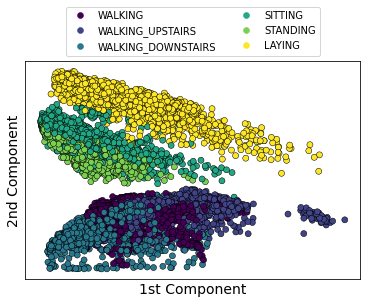

In [20]:
plt.figure(figsize = (6,4))
plot_scatter(latent, y_train, activities)
# plt.savefig('autoencoder_dim_red.pdf', bbox_inches = 'tight')
plt.show()

In [16]:
autoencoder.evaluate(X_test_full, X_test_full)

93/93 [==============================] - 0s 398us/step - loss: 0.0307


0.030667118728160858

In [17]:
autoencoder.evaluate(X_train_full, X_train_full)

228/228 [==============================] - 0s 382us/step - loss: 0.0296


0.029593801125884056

In [18]:
dtc_autoencoder = DTC(random_state = 5, min_samples_leaf = 20).fit(latent, y_train)

In [19]:
X_test_latent = stacked_encoder.predict(X_test_full)
y_pred = dtc_autoencoder.predict(X_test_latent)

In [20]:
print(classification_report(y_test, y_pred, target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.56      0.60      0.58       496
  WALKING_UPSTAIRS       0.85      0.75      0.80       471
WALKING_DOWNSTAIRS       0.59      0.62      0.61       420
           SITTING       0.70      0.58      0.63       491
          STANDING       0.68      0.81      0.74       532
            LAYING       0.99      0.95      0.97       537

          accuracy                           0.73      2947
         macro avg       0.73      0.72      0.72      2947
      weighted avg       0.73      0.73      0.73      2947



In [21]:
knn_autoencoder = KNN(n_jobs = -1).fit(latent, y_train)

In [22]:
y_pred = knn_autoencoder.predict(X_test_latent)

In [23]:
print(classification_report(y_test, y_pred, target_names = activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.54      0.64      0.59       496
  WALKING_UPSTAIRS       0.82      0.74      0.78       471
WALKING_DOWNSTAIRS       0.63      0.55      0.59       420
           SITTING       0.68      0.56      0.61       491
          STANDING       0.66      0.80      0.72       532
            LAYING       1.00      0.96      0.98       537

          accuracy                           0.72      2947
         macro avg       0.72      0.71      0.71      2947
      weighted avg       0.73      0.72      0.72      2947



# Classification

In [11]:
# let's remove the LAYING activity from the train set

filter_idx = y_train[y_train != 6].index
y_train = y_train[filter_idx]
X_train = X_train.loc[filter_idx, :]

In [12]:
X_train.shape, y_train.shape

((5896, 23), (5896,))

In [13]:
# let's remove the LAYING activity from the test set

filter_idx = y_test[y_test != 6].index
y_test = y_test[filter_idx]
X_test = X_test.loc[filter_idx, :]

In [14]:
X_test.shape, y_test.shape

((2410, 23), (2410,))

In [678]:
del activities[6]

In [679]:
activities

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING'}

In [15]:
# classes should start from 0, thus we scale each label by one

y_train_scaled = y_train.map({n:n-1 for n in y_train})
y_test_scaled = y_test.map({n:n-1 for n in y_test})

In [16]:
y_train_scaled.unique()

array([4, 3, 0, 2, 1], dtype=int64)

In [17]:
# Keras for multi-class classification requires that the 
# target variable be a one-hot numeric array.

y_train_onehot = to_categorical(y_train_scaled, num_classes = 5)
y_test_onehot = to_categorical(y_test_scaled, num_classes = 5)

In [18]:
y_train_onehot

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [19]:
y_train_onehot.shape

(5896, 5)

In [20]:
# create a validation set from the train set

X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train_onehot, train_size = 0.8, random_state = 5)

In [21]:
X_tr = X_tr.values
X_valid = X_valid.values
X_test = X_test.values
X_train = X_train.values

---

## Multi-Layer Perceptron with One Hidden-Layer

https://keras.io/api/layers/core_layers/dense/ \
https://keras.io/api/losses/ \
https://keras.io/api/optimizers/ \
https://keras.io/api/metrics/

### Hidden neurons tuning

First we tune the optimal number of neurons in the hidden layer.

In [35]:
params = {'h_layer_neurons': [n for n in range(2, 47)]}

In [126]:
def mpl_1_hidden(h_layer_neurons = 18, n_features = 23, opt = None,
                 lr = None, activation = 'relu', 
                 init = 'glorot_uniform'):
    model = Sequential([
        Input(shape = (n_features,)),
        Dense(h_layer_neurons, activation = activation,
              kernel_initializer = init),
        Dense(5, activation = 'softmax')
    ])
    loss = 'categorical_crossentropy'
    if opt is None:
        model.compile(loss = loss, metrics=['accuracy'])
    else:
        opt = opt(learning_rate = lr)
        model.compile(loss = loss, optimizer = opt,
                      metrics=['accuracy'])
    return model

In [37]:
mlp1 = KerasClassifier(mpl_1_hidden)

In [38]:
gridsearch = GridSearchCV(mlp1, params, cv = 5, n_jobs = -1)

In [39]:
stop = EarlyStopping(patience = 10)
gridsearch.fit(X_tr, y_tr, callbacks = [stop], epochs = 100,
               validation_data = (X_valid, y_valid))

Epoch 1/100
148/148 [==============================] - 0s 899us/step - loss: 1.2004 - accuracy: 0.6503 - val_loss: 0.8685 - val_accuracy: 0.8475
Epoch 2/100
148/148 [==============================] - 0s 419us/step - loss: 0.6872 - accuracy: 0.8588 - val_loss: 0.5420 - val_accuracy: 0.8746
Epoch 3/100
148/148 [==============================] - 0s 406us/step - loss: 0.4738 - accuracy: 0.8734 - val_loss: 0.4080 - val_accuracy: 0.8898
Epoch 4/100
148/148 [==============================] - 0s 413us/step - loss: 0.3765 - accuracy: 0.8868 - val_loss: 0.3408 - val_accuracy: 0.8975
Epoch 5/100
148/148 [==============================] - 0s 413us/step - loss: 0.3281 - accuracy: 0.8899 - val_loss: 0.3034 - val_accuracy: 0.8983
Epoch 6/100
148/148 [==============================] - 0s 413us/step - loss: 0.2985 - accuracy: 0.8946 - val_loss: 0.2873 - val_accuracy: 0.9110
Epoch 7/100
148/148 [==============================] - 0s 413us/step - loss: 0.2788 - accuracy: 0.8965 - val_loss: 0.2623 - val_ac

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000029E9322AC10>,
             n_jobs=-1,
             param_grid={'h_layer_neurons': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19, 20, 21,
                                             22, 23, 24, 25, 26, 27, 28, 29, 30,
                                             31, ...]})

In [40]:
gridsearch.best_params_

{'h_layer_neurons': 40}

In [41]:
gridsearch.best_score_

0.9376608729362488

In [42]:
best_model = gridsearch.best_estimator_

In [43]:
best_model_history = best_model.model.history.history

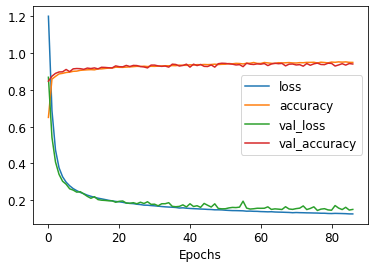

In [44]:
# Learning curves for the best model: 
# mean loss and accuracy measured on both train set and 
# validation set over each epoch

pd.DataFrame(best_model_history).plot(figsize=(6, 4))
plt.xlabel('Epochs')
plt.show()

The model does not overfit the train set. Moreover, note that the model does not perform all the 100 epochs because it reached the 
early stop.

In [45]:
results = gridsearch.cv_results_

In [121]:
report(results, 5)

Model with rank: 1
Mean validation score: 0.938 (std: 0.010)
Parameters: {'h_layer_neurons': 40}

Model with rank: 2
Mean validation score: 0.937 (std: 0.006)
Parameters: {'h_layer_neurons': 41}

Model with rank: 3
Mean validation score: 0.936 (std: 0.008)
Parameters: {'h_layer_neurons': 42}

Model with rank: 4
Mean validation score: 0.936 (std: 0.010)
Parameters: {'h_layer_neurons': 44}

Model with rank: 5
Mean validation score: 0.935 (std: 0.008)
Parameters: {'h_layer_neurons': 36}



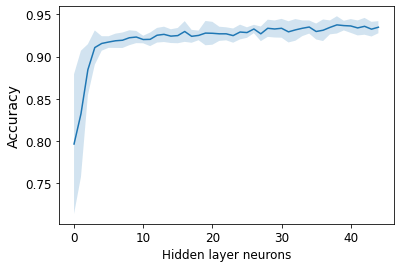

In [47]:
# mean validation score (cross folds) for each model

ax = plot_score(results)
ax.set_xlabel('Hidden layer neurons')
ax.set_ylabel('Accuracy', fontsize=14)
plt.show()

As we can see, from 6 to 46 neurons in the hidden layer the performance increase very slowly.

Before train the model on the whole train set without using the validation set, let's evaluate how the best trained model behaves with unseen data

In [22]:
name_sets = ['(X_train, y_train_onehot)', '(X_test, y_test_onehot)',
            '(X_tr, y_tr)', '(X_valid, y_valid)']

X_y_sets = [(X_train, y_train_onehot), (X_test, y_test_onehot),
            (X_tr, y_tr), (X_valid, y_valid)]

In [109]:
print('(X, y):[loss, accuracy]')
for name, pair in zip(name_sets,X_y_sets):
    measures = best_model.model.evaluate(*pair, verbose = 0)
    print(name +':', np.around(measures, 5))

(X, y):[loss, accuracy]
(X_train, y_train_onehot): [0.12693 0.95217]
(X_test, y_test_onehot): [0.4119  0.85477]
(X_tr, y_tr): [0.12111 0.95505]
(X_valid, y_valid): [0.15019 0.94068]


However, the model was able to overfit both train and validation set. Indeed, the loss on the test set is 3 times larger then those computed on both train and validation set. We should evaluate a model with a lower numer of neurons. So now we evaluate different models on the test set in order to choose the one that overfit less. Here we do not use the validation set any more sence we already know the performance of all the models on this set.

---

In [52]:
# let's try with 23 hidden nodes (the same number of the iniput layer)

mpl_23 = mpl_1_hidden(h_layer_neurons = 23)

In [53]:
mpl_23.fit(X_train, y_train_onehot, epochs = 78)

Epoch 1/78
185/185 [==============================] - 0s 308us/step - loss: 1.2632 - accuracy: 0.5565
Epoch 2/78
185/185 [==============================] - 0s 303us/step - loss: 0.8040 - accuracy: 0.8145
Epoch 3/78
185/185 [==============================] - 0s 308us/step - loss: 0.5595 - accuracy: 0.8569
Epoch 4/78
185/185 [==============================] - 0s 303us/step - loss: 0.4343 - accuracy: 0.8697
Epoch 5/78
185/185 [==============================] - 0s 303us/step - loss: 0.3648 - accuracy: 0.8814
Epoch 6/78
185/185 [==============================] - 0s 319us/step - loss: 0.3230 - accuracy: 0.8882
Epoch 7/78
185/185 [==============================] - 0s 325us/step - loss: 0.2957 - accuracy: 0.8950
Epoch 8/78
185/185 [==============================] - 0s 319us/step - loss: 0.2772 - accuracy: 0.8976
Epoch 9/78
185/185 [==============================] - 0s 325us/step - loss: 0.2626 - accuracy: 0.9003
Epoch 10/78
185/185 [==============================] - 0s 325us/step - loss: 0.251

In [112]:
print('(X, y):[loss, accuracy]')
for name, pair in zip(name_sets,X_y_sets):
    measures = mpl_23.evaluate(*pair, verbose = 0)
    print(name +':', np.around(measures, 5))

(X, y):[loss, accuracy]
(X_train, y_train_onehot): [0.14302 0.94267]
(X_test, y_test_onehot): [0.41858 0.85643]
(X_tr, y_tr): [0.14393 0.94211]
(X_valid, y_valid): [0.13939 0.94492]


With 23 hidden nodes we obtain better results on the test stet: a slightly larger accuracy and a smaller overfit. 

---

In [122]:
# let's try with 18 hidden neurons

mpl_18 = mpl_1_hidden(h_layer_neurons = 16)

In [123]:
mpl_18.fit(X_train, y_train_onehot, epochs = 78)

Epoch 1/78
185/185 [==============================] - 0s 308us/step - loss: 1.4099 - accuracy: 0.3716
Epoch 2/78
185/185 [==============================] - 0s 308us/step - loss: 0.9878 - accuracy: 0.7103
Epoch 3/78
185/185 [==============================] - 0s 303us/step - loss: 0.7418 - accuracy: 0.8063
Epoch 4/78
185/185 [==============================] - 0s 303us/step - loss: 0.5908 - accuracy: 0.8396
Epoch 5/78
185/185 [==============================] - 0s 298us/step - loss: 0.4886 - accuracy: 0.8606
Epoch 6/78
185/185 [==============================] - 0s 314us/step - loss: 0.4198 - accuracy: 0.8723
Epoch 7/78
185/185 [==============================] - 0s 308us/step - loss: 0.3721 - accuracy: 0.8828
Epoch 8/78
185/185 [==============================] - 0s 319us/step - loss: 0.3394 - accuracy: 0.8879
Epoch 9/78
185/185 [==============================] - 0s 308us/step - loss: 0.3157 - accuracy: 0.8933
Epoch 10/78
185/185 [==============================] - 0s 325us/step - loss: 0.297

In [124]:
print('(X, y):[loss, accuracy]')
for name, pair in zip(name_sets,X_y_sets):
    measures = mpl_18.evaluate(*pair, verbose = 0)
    print(name +':', np.around(measures, 5))

(X, y):[loss, accuracy]
(X_train, y_train_onehot): [0.15561 0.93962]
(X_test, y_test_onehot): [0.39218 0.86929]
(X_tr, y_tr): [0.15787 0.93766]
(X_valid, y_valid): [0.14658 0.94746]


Again the model overfit

---

In [64]:
# let's try with int((#input + #output)/2) hidden neurons

mpl_14 = mpl_1_hidden(h_layer_neurons = 14)

In [65]:
mpl_14.fit(X_train, y_train_onehot, epochs = 78)

Epoch 1/78
185/185 [==============================] - 0s 303us/step - loss: 1.4248 - accuracy: 0.3689
Epoch 2/78
185/185 [==============================] - 0s 319us/step - loss: 1.0203 - accuracy: 0.7539
Epoch 3/78
185/185 [==============================] - 0s 308us/step - loss: 0.7378 - accuracy: 0.8358
Epoch 4/78
185/185 [==============================] - 0s 319us/step - loss: 0.5659 - accuracy: 0.8631
Epoch 5/78
185/185 [==============================] - 0s 308us/step - loss: 0.4651 - accuracy: 0.8733
Epoch 6/78
185/185 [==============================] - 0s 308us/step - loss: 0.4008 - accuracy: 0.8787
Epoch 7/78
185/185 [==============================] - 0s 314us/step - loss: 0.3587 - accuracy: 0.8865
Epoch 8/78
185/185 [==============================] - 0s 319us/step - loss: 0.3287 - accuracy: 0.8867
Epoch 9/78
185/185 [==============================] - 0s 314us/step - loss: 0.3069 - accuracy: 0.8887
Epoch 10/78
185/185 [==============================] - 0s 335us/step - loss: 0.289

In [114]:
print('(X, y):[loss, accuracy]')
for name, pair in zip(name_sets,X_y_sets):
    measures = mpl_14.evaluate(*pair, verbose = 0)
    print(name +':', np.around(measures, 5))

(X, y):[loss, accuracy]
(X_train, y_train_onehot): [0.1529  0.93368]
(X_test, y_test_onehot): [0.41723 0.85062]
(X_tr, y_tr): [0.15301 0.93321]
(X_valid, y_valid): [0.15247 0.93559]


It does not seem to change anything

---

In [70]:
# let's try with 7 hidden neurons

mpl_7 = mpl_1_hidden(h_layer_neurons = 7)

In [71]:
mpl_7.fit(X_train, y_train_onehot, epochs = 78)

Epoch 1/78
185/185 [==============================] - 0s 298us/step - loss: 1.4859 - accuracy: 0.4264
Epoch 2/78
185/185 [==============================] - 0s 308us/step - loss: 1.1937 - accuracy: 0.5924
Epoch 3/78
185/185 [==============================] - 0s 308us/step - loss: 0.9297 - accuracy: 0.7118
Epoch 4/78
185/185 [==============================] - 0s 303us/step - loss: 0.7414 - accuracy: 0.7948
Epoch 5/78
185/185 [==============================] - 0s 303us/step - loss: 0.6152 - accuracy: 0.8323
Epoch 6/78
185/185 [==============================] - 0s 308us/step - loss: 0.5294 - accuracy: 0.8482
Epoch 7/78
185/185 [==============================] - 0s 303us/step - loss: 0.4718 - accuracy: 0.8584
Epoch 8/78
185/185 [==============================] - 0s 314us/step - loss: 0.4290 - accuracy: 0.8660
Epoch 9/78
185/185 [==============================] - 0s 319us/step - loss: 0.3975 - accuracy: 0.8713
Epoch 10/78
185/185 [==============================] - 0s 319us/step - loss: 0.373

In [115]:
print('(X, y):[loss, accuracy]')
for name, pair in zip(name_sets,X_y_sets):
    measures = mpl_7.evaluate(*pair, verbose = 0)
    print(name +':', np.around(measures, 5))

(X, y):[loss, accuracy]
(X_train, y_train_onehot): [0.19453 0.92707]
(X_test, y_test_onehot): [0.36368 0.86722]
(X_tr, y_tr): [0.19446 0.926  ]
(X_valid, y_valid): [0.19481 0.93136]


Again, the model continue to overfit the train set

---

In [76]:
# let's try with 5 hidden neurons

mpl_5 = mpl_1_hidden(h_layer_neurons = 5)

In [77]:
mpl_5.fit(X_train, y_train_onehot, epochs = 78)

Epoch 1/78
185/185 [==============================] - 0s 319us/step - loss: 1.5607 - accuracy: 0.3609
Epoch 2/78
185/185 [==============================] - 0s 314us/step - loss: 1.3239 - accuracy: 0.6367
Epoch 3/78
185/185 [==============================] - 0s 346us/step - loss: 1.0891 - accuracy: 0.7683
Epoch 4/78
185/185 [==============================] - 0s 325us/step - loss: 0.8461 - accuracy: 0.8301
Epoch 5/78
185/185 [==============================] - 0s 314us/step - loss: 0.6633 - accuracy: 0.8572
Epoch 6/78
185/185 [==============================] - 0s 314us/step - loss: 0.5478 - accuracy: 0.8645
Epoch 7/78
185/185 [==============================] - 0s 314us/step - loss: 0.4728 - accuracy: 0.8694
Epoch 8/78
185/185 [==============================] - 0s 330us/step - loss: 0.4216 - accuracy: 0.8740
Epoch 9/78
185/185 [==============================] - 0s 319us/step - loss: 0.3868 - accuracy: 0.8765
Epoch 10/78
185/185 [==============================] - 0s 319us/step - loss: 0.360

In [116]:
print('(X, y):[loss, accuracy]')
for name, pair in zip(name_sets,X_y_sets):
    measures = mpl_5.evaluate(*pair, verbose = 0)
    print(name +':', np.around(measures, 5))

(X, y):[loss, accuracy]
(X_train, y_train_onehot): [0.2029  0.91842]
(X_test, y_test_onehot): [0.39944 0.85809]
(X_tr, y_tr): [0.20426 0.91645]
(X_valid, y_valid): [0.19746 0.92627]


In general, changing the number of hidden nodes doesn't seems to make a big difference and this also depend on the randomness introduced in the model with the initialization. Probably we can choose the model with 18 hidden nodes because maybe have a good compromise between loss and accuracy.

---

### Initialization and activation function tuning

https://keras.io/api/layers/initializers/ \
https://keras.io/api/layers/activations/

In [128]:
# from keras.initializers import Zeros, Ones, GlorotNormal, \
#     GlorotUniform, HeNormal, HeUniform

In [186]:
params = {'activation': ['relu', 'sigmoid', 'softplus', 'tanh', 
                         'elu'],
          'init': ['glorot_normal', 'glorot_uniform', 'he_normal',
                   'he_uniform', 'zeros', 'ones']}

param_list = [params, 
              {'activation': ['selu'], 'init': ['lecun_normal']}]

In [187]:
mlp1_init = KerasClassifier(mpl_1_hidden)

In [188]:
gridsearch_init = GridSearchCV(mlp1_init, param_list, cv = 5,
                             n_jobs = -1,error_score='raise')

In [189]:
stop = EarlyStopping(patience = 10)
gridsearch_init.fit(X_tr, y_tr, callbacks = [stop], epochs = 100,
                    validation_data = (X_valid, y_valid))

Epoch 1/100
148/148 [==============================] - 0s 879us/step - loss: 1.3821 - accuracy: 0.4584 - val_loss: 1.1165 - val_accuracy: 0.6356
Epoch 2/100
148/148 [==============================] - 0s 413us/step - loss: 0.9197 - accuracy: 0.7513 - val_loss: 0.7678 - val_accuracy: 0.7966
Epoch 3/100
148/148 [==============================] - 0s 413us/step - loss: 0.6689 - accuracy: 0.8361 - val_loss: 0.5793 - val_accuracy: 0.8466
Epoch 4/100
148/148 [==============================] - 0s 406us/step - loss: 0.5204 - accuracy: 0.8639 - val_loss: 0.4620 - val_accuracy: 0.8644
Epoch 5/100
148/148 [==============================] - 0s 406us/step - loss: 0.4305 - accuracy: 0.8781 - val_loss: 0.3898 - val_accuracy: 0.8831
Epoch 6/100
148/148 [==============================] - 0s 413us/step - loss: 0.3728 - accuracy: 0.8868 - val_loss: 0.3445 - val_accuracy: 0.8924
Epoch 7/100
148/148 [==============================] - 0s 399us/step - loss: 0.3360 - accuracy: 0.8885 - val_loss: 0.3140 - val_ac

GridSearchCV(cv=5, error_score='raise',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000029E9F3D1370>,
             n_jobs=-1,
             param_grid=[{'activation': ['relu', 'sigmoid', 'softplus', 'tanh',
                                         'elu'],
                          'init': ['glorot_normal', 'glorot_uniform',
                                   'he_normal', 'he_uniform', 'zeros',
                                   'ones']},
                         {'activation': ['selu'], 'init': ['lecun_normal']}])

In [191]:
results = gridsearch_init.cv_results_

In [200]:
report(results, 3)

Model with rank: 1
Mean validation score: 0.930 (std: 0.008)
Parameters: {'activation': 'tanh', 'init': 'he_normal'}

Model with rank: 2
Mean validation score: 0.930 (std: 0.007)
Parameters: {'activation': 'tanh', 'init': 'glorot_normal'}

Model with rank: 3
Mean validation score: 0.930 (std: 0.010)
Parameters: {'activation': 'relu', 'init': 'he_uniform'}



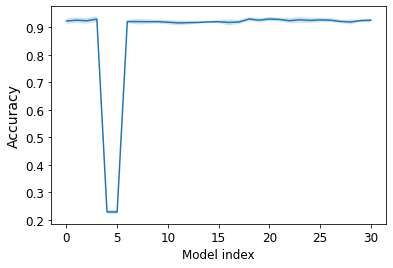

In [201]:
ax = plot_score(results)
ax.set_xlabel('Model index')
ax.set_ylabel('Accuracy', fontsize=14)
plt.show()

The choices about activation functions and initialization approaches do not appear relevant. The only important fact to note is the huge drop caused by the 4th and 5th model. Particularly, it is due to the combinations (relu, zeros) and (relu,ones). 

In [205]:
best_model_init = gridsearch_init.best_estimator_
best_model_init_history = best_model_init.model.history.history

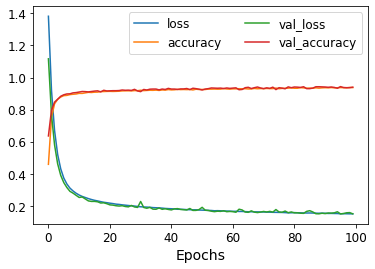

In [213]:
pd.DataFrame(best_model_init_history).plot(figsize=(6, 4))
plt.xlabel('Epochs')
plt.legend(loc = 'upper right', ncol = 2)
plt.xlabel('Epochs', fontsize = 14)
plt.show()

In [215]:
cols = ['param_init', 'param_activation', 'mean_test_score', 
        'std_test_score', 'rank_test_score']
df_params= pd.DataFrame(results)[cols]

In [217]:
df_params = df_params.sort_values(['param_activation','rank_test_score']).reset_index(drop = True)

In [218]:
df_params

,param_init,param_activation,mean_test_score,std_test_score,rank_test_score
0,glorot_uniform,elu,0.927056,0.008201,6
1,he_normal,elu,0.926210,0.007291,7
2,glorot_normal,elu,0.925362,0.009968,11
3,ones,elu,0.924512,0.005256,12
4,he_uniform,elu,0.921545,0.006380,16
5,zeros,elu,0.919636,0.008974,23
6,he_uniform,relu,0.930028,0.010434,3
7,glorot_uniform,relu,0.926208,0.010054,9
8,he_normal,relu,0.923878,0.010403,14
9,glorot_normal,relu,0.923027,0.010255,15


---

### Optimizer and learning rate tuning

Let's now tune the optimizer and the learning rate using the optimal number if hidden neurons just found.

In [23]:
adam = keras.optimizers.Adam
sgd = keras.optimizers.SGD
rmsprop = keras.optimizers.RMSprop
nadam = keras.optimizers.Nadam

In [22]:
params = {'opt': [adam, sgd, rmsprop, nadam],
          'lr': [1., 0.5, 0.2, 0.15, 0.1, 0.05, 0.01, 5e-3, 
                 1e-3, 5e-4, 1e-4, 5e-5, 1e-5]}

In [245]:
mlp1_opt = KerasClassifier(mpl_1_hidden)

In [246]:
gridsearch_opt = GridSearchCV(mlp1_opt, params, cv = 5, n_jobs = -1)

In [247]:
stop = EarlyStopping(patience = 10)
gridsearch_opt.fit(X_tr, y_tr, callbacks = [stop], epochs = 100,
               validation_data = (X_valid, y_valid))

Epoch 1/100
148/148 [==============================] - 0s 967us/step - loss: 0.6280 - accuracy: 0.7833 - val_loss: 0.3053 - val_accuracy: 0.8924
Epoch 2/100
148/148 [==============================] - 0s 467us/step - loss: 0.2810 - accuracy: 0.8944 - val_loss: 0.2692 - val_accuracy: 0.9102
Epoch 3/100
148/148 [==============================] - 0s 460us/step - loss: 0.2399 - accuracy: 0.9082 - val_loss: 0.2103 - val_accuracy: 0.9110
Epoch 4/100
148/148 [==============================] - 0s 453us/step - loss: 0.2210 - accuracy: 0.9086 - val_loss: 0.2172 - val_accuracy: 0.9119
Epoch 5/100
148/148 [==============================] - 0s 460us/step - loss: 0.2136 - accuracy: 0.9169 - val_loss: 0.2193 - val_accuracy: 0.9136
Epoch 6/100
148/148 [==============================] - 0s 453us/step - loss: 0.2041 - accuracy: 0.9162 - val_loss: 0.2190 - val_accuracy: 0.9178
Epoch 7/100
148/148 [==============================] - 0s 426us/step - loss: 0.1970 - accuracy: 0.9188 - val_loss: 0.1854 - val_ac

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000029EA13C1DF0>,
             n_jobs=-1,
             param_grid={'lr': [1.0, 0.5, 0.2, 0.15, 0.1, 0.05, 0.01, 0.005,
                                0.001, 0.0005, 0.0001, 5e-05, 1e-05],
                         'opt': [<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>,
                                 <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>,
                                 <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>,
                                 <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>]})

In [248]:
gridsearch_opt.best_params_

{'lr': 0.01, 'opt': tensorflow.python.keras.optimizer_v2.nadam.Nadam}

In [249]:
gridsearch_opt.best_score_

0.9357493758201599

In [250]:
best_model_opt = gridsearch_opt.best_estimator_

In [251]:
best_model_opt_history = best_model_opt.model.history.history

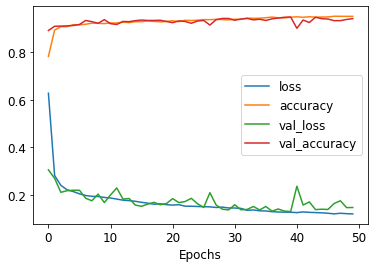

In [252]:
pd.DataFrame(best_model_opt_history).plot(figsize=(6, 4))
plt.xlabel('Epochs')
plt.show()

Also in this case, the model does not seem to overfit over the train set. Again, the model reach the early stop before to run all the epochs.

In [253]:
results = gridsearch_opt.cv_results_

In [254]:
report(results, 3)

Model with rank: 1
Mean validation score: 0.936 (std: 0.010)
Parameters: {'lr': 0.01, 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}

Model with rank: 2
Mean validation score: 0.935 (std: 0.010)
Parameters: {'lr': 0.01, 'opt': <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>}

Model with rank: 3
Mean validation score: 0.934 (std: 0.006)
Parameters: {'lr': 0.005, 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}



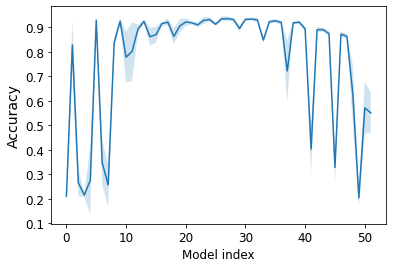

In [255]:
ax = plot_score(results)
ax.set_xlabel('Model index')
ax.set_ylabel('Accuracy', fontsize=14)
plt.show()

In [264]:
df_params = pd.DataFrame(results)[['param_lr', 'param_opt', 'mean_test_score', 'std_test_score', 'rank_test_score']]

df_params['param_opt'] = df_params['param_opt'].astype(str)

def f_change_label(string):
    if 'nadam' in string: return 'Nadam'
    elif 'adam' in string: return 'Adam'
    elif 'SGD' in string: return 'SGD' 
    elif 'rmsprop' in string: return 'RMSprop'
    
      
df_params['param_opt'] = df_params['param_opt'].apply(f_change_label)

In [265]:
df_params.head(3)

,param_lr,param_opt,mean_test_score,std_test_score,rank_test_score
0,1.0,Adam,0.209495,0.022699,51
1,1.0,SGD,0.828500,0.104609,37
2,1.0,RMSprop,0.264626,0.054037,48


In [266]:
df_params = df_params.sort_values(['param_opt','rank_test_score']).reset_index(drop = True)

In [267]:
df_params

,param_lr,param_opt,mean_test_score,std_test_score,rank_test_score
0,0.01,Adam,0.932144,0.009474,5
1,0.005,Adam,0.931936,0.007391,6
2,0.001,Adam,0.930663,0.009771,7
3,0.05,Adam,0.921969,0.015441,14
4,0.0005,Adam,0.920272,0.007568,17
5,0.1,Adam,0.915185,0.007253,20
6,0.0001,Adam,0.893977,0.010242,25
7,0.15,Adam,0.893561,0.016770,26
8,0.00005,Adam,0.874681,0.010342,29
9,0.2,Adam,0.837795,0.024057,36


---

In the end, putting all these grid searches together we obtain the following optimal model:
* hidden nodes = 40
* initialization = he_normal
* activation = tanh
* lr = 0.01;
* optimizer: Nadam (with default hyperparameters)
* early stopping 

Let's now tune again the the number of neurons in the hidden layer but using the optimal hyperparameters just found.

In [195]:
def build_model(h_layer_neurons = 18):
    model = Sequential([
        Input(shape = (23,)),
        Dense(
              h_layer_neurons, activation = 'tanh',
              kernel_initializer = 'he_normal'
        ),
        Dense(5, activation = 'softmax')
    ])
    loss = 'categorical_crossentropy'
    opt = keras.optimizers.Nadam(learning_rate = 0.01)
    metrics = ['accuracy']
    model.compile(loss = loss, optimizer = opt, metrics = metrics)
    return model

In [196]:
params = {'h_layer_neurons': [n for n in range(2, 47)]}

In [197]:
mlp1 = KerasClassifier(build_model)

In [198]:
gridsearch = GridSearchCV(mlp1, params, cv = 5, n_jobs = -1)

In [199]:
stop = EarlyStopping(patience = 10)
gridsearch.fit(X_tr, y_tr, callbacks = [stop], epochs = 100,
               validation_data = (X_valid, y_valid))

Epoch 1/100
148/148 [==============================] - 0s 920us/step - loss: 0.5128 - accuracy: 0.8212 - val_loss: 0.2695 - val_accuracy: 0.9008
Epoch 2/100
148/148 [==============================] - 0s 440us/step - loss: 0.2551 - accuracy: 0.9008 - val_loss: 0.2148 - val_accuracy: 0.9203
Epoch 3/100
148/148 [==============================] - 0s 426us/step - loss: 0.2232 - accuracy: 0.9126 - val_loss: 0.2359 - val_accuracy: 0.9068
Epoch 4/100
148/148 [==============================] - 0s 467us/step - loss: 0.2072 - accuracy: 0.9128 - val_loss: 0.1901 - val_accuracy: 0.9161
Epoch 5/100
148/148 [==============================] - 0s 473us/step - loss: 0.1952 - accuracy: 0.9171 - val_loss: 0.3064 - val_accuracy: 0.8864
Epoch 6/100
148/148 [==============================] - 0s 473us/step - loss: 0.1871 - accuracy: 0.9232 - val_loss: 0.1734 - val_accuracy: 0.9339
Epoch 7/100
148/148 [==============================] - 0s 487us/step - loss: 0.1784 - accuracy: 0.9203 - val_loss: 0.1575 - val_ac

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001E0DC00F3D0>,
             n_jobs=-1,
             param_grid={'h_layer_neurons': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19, 20, 21,
                                             22, 23, 24, 25, 26, 27, 28, 29, 30,
                                             31, ...]})

In [200]:
gridsearch.best_params_

{'h_layer_neurons': 46}

In [201]:
gridsearch.best_score_

0.9563179612159729

In [202]:
best_model = gridsearch.best_estimator_

In [203]:
best_model_history = best_model.model.history.history

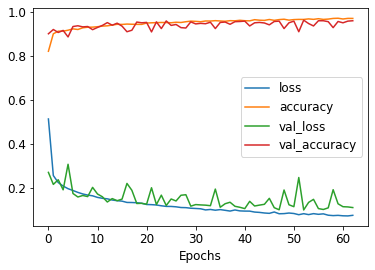

In [204]:
pd.DataFrame(best_model_history).plot(figsize=(6, 4))
plt.xlabel('Epochs')
plt.show()

In [205]:
results = gridsearch.cv_results_

In [206]:
report(results, 5)

Model with rank: 1
Mean validation score: 0.956 (std: 0.006)
Parameters: {'h_layer_neurons': 46}

Model with rank: 2
Mean validation score: 0.954 (std: 0.002)
Parameters: {'h_layer_neurons': 34}

Model with rank: 3
Mean validation score: 0.954 (std: 0.006)
Parameters: {'h_layer_neurons': 43}

Model with rank: 4
Mean validation score: 0.954 (std: 0.006)
Parameters: {'h_layer_neurons': 44}

Model with rank: 5
Mean validation score: 0.954 (std: 0.006)
Parameters: {'h_layer_neurons': 31}



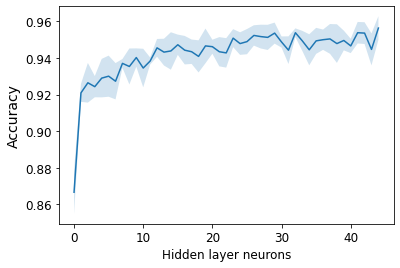

In [207]:
ax = plot_score(results)
ax.set_xlabel('Hidden layer neurons')
ax.set_ylabel('Accuracy', fontsize=14)
plt.show()

In [208]:
for name, pair in zip(name_sets,X_y_sets):
    measures = best_model.model.evaluate(*pair, verbose = 0)
    loss, acc = np.around(measures, 5)
    print(f'Loss = {loss}, Accuracy = {acc}, Dataset = {name}')

Loss = 0.0736, Accuracy = 0.96913, Dataset = (X_train, y_train_onehot)
Loss = 0.8875, Accuracy = 0.8166, Dataset = (X_test, y_test_onehot)
Loss = 0.06467, Accuracy = 0.97137, Dataset = (X_tr, y_tr)
Loss = 0.1093, Accuracy = 0.96017, Dataset = (X_valid, y_valid)


In [211]:
# let's try with 31 hidden neurons

mpl_31 = build_model(h_layer_neurons = 20)
mpl_31.fit(X_train, y_train_onehot,epochs = 100, verbose = 0)

In [212]:
for name, pair in zip(name_sets,X_y_sets):
    measures = mpl_31.evaluate(*pair, verbose = 0)
    loss, acc = np.around(measures, 5)
    print(f'Loss = {loss}, Accuracy = {acc}, Dataset = {name}')

Loss = 0.06852, Accuracy = 0.97303, Dataset = (X_train, y_train_onehot)
Loss = 0.75819, Accuracy = 0.83154, Dataset = (X_test, y_test_onehot)
Loss = 0.06597, Accuracy = 0.97519, Dataset = (X_tr, y_tr)
Loss = 0.07871, Accuracy = 0.96441, Dataset = (X_valid, y_valid)


---

Since the model doesn't seem to generalize well on the test set, let's repet the grid search introducing the $\ell_2$ regularization in order to reduce the overfitting.

In [217]:
def mpl_1_hidden(h_layer_neurons = 18, n_features = 23, opt = None,
                 lr = None, activation = 'relu', 
                 init = 'glorot_uniform'):
    model = Sequential([
        Input(shape = (n_features,)),
        Dense(
              h_layer_neurons, activation = activation,
              kernel_initializer = init,
              kernel_regularizer = l2(0.01)
        ),
        Dense(5, activation = 'softmax')
    ])
    loss = 'categorical_crossentropy'
    if opt is None:
        model.compile(loss = loss, metrics=['accuracy'])
    else:
        opt = opt(learning_rate = lr)
        model.compile(loss = loss, optimizer = opt,
                      metrics=['accuracy'])
    return model

In [218]:
params1 = {'activation': ['relu','tanh','elu'],
          'init': ['he_normal','he_uniform'],
          'h_layer_neurons': [7, 10, 12, 14, 18, 23, 40, 46],
          'opt': [rmsprop, nadam],
          'lr': [0.01, 0.005, 0.008]
}


params2 = {'h_layer_neurons': [n for n in range(2, 47)],
           'activation': ['selu'], 'init': ['lecun_normal'],
           'opt': [rmsprop, nadam],
           'lr': [0.01, 0.005, 0.008]
}

param_list = [params1, params2]

In [219]:
mlp1_full = KerasClassifier(mpl_1_hidden)

In [220]:
gridsearch_full = GridSearchCV(mlp1_full, param_list, cv = 5, n_jobs = -1)

In [221]:
stop = EarlyStopping(patience = 10)
gridsearch_full.fit(X_tr, y_tr, callbacks = [stop], epochs = 100,
               validation_data = (X_valid, y_valid))

Epoch 1/100
148/148 [==============================] - 0s 987us/step - loss: 0.9278 - accuracy: 0.7822 - val_loss: 0.5930 - val_accuracy: 0.8754
Epoch 2/100
148/148 [==============================] - 0s 453us/step - loss: 0.5052 - accuracy: 0.8857 - val_loss: 0.5079 - val_accuracy: 0.8602
Epoch 3/100
148/148 [==============================] - 0s 440us/step - loss: 0.4237 - accuracy: 0.8946 - val_loss: 0.4836 - val_accuracy: 0.8720
Epoch 4/100
148/148 [==============================] - 0s 433us/step - loss: 0.3933 - accuracy: 0.8936 - val_loss: 0.3541 - val_accuracy: 0.9085
Epoch 5/100
148/148 [==============================] - 0s 433us/step - loss: 0.3699 - accuracy: 0.8980 - val_loss: 0.4195 - val_accuracy: 0.8610
Epoch 6/100
148/148 [==============================] - 0s 433us/step - loss: 0.3487 - accuracy: 0.9037 - val_loss: 0.3557 - val_accuracy: 0.9119
Epoch 7/100
148/148 [==============================] - 0s 440us/step - loss: 0.3409 - accuracy: 0.8986 - val_loss: 0.3216 - val_ac

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001E0DE1F0850>,
             n_jobs=-1,
             param_grid=[{'activation': ['relu', 'tanh', 'elu'],
                          'h_layer_neurons': [7, 10, 12, 14, 18, 23, 40, 46],
                          'init': ['he_normal', 'he_uniform'],
                          'lr': [0.01, 0.005, 0.008],
                          'opt': [<class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>,
                                  <cla....python.keras.optimizer_v2.nadam.Nadam'>]},
                         {'activation': ['selu'],
                          'h_layer_neurons': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, 31, ...],
                          'init': ['lecun_nor

In [222]:
gridsearch_full.best_params_

{'activation': 'selu',
 'h_layer_neurons': 31,
 'init': 'lecun_normal',
 'lr': 0.005,
 'opt': tensorflow.python.keras.optimizer_v2.nadam.Nadam}

In [223]:
gridsearch_full.best_score_

0.9238768696784974

In [224]:
best_model_full = gridsearch_full.best_estimator_

In [225]:
best_model_full_history = best_model_full.model.history.history

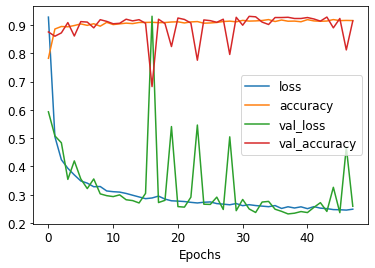

In [226]:
pd.DataFrame(best_model_full_history).plot(figsize=(6, 4))
plt.xlabel('Epochs')
plt.show()

Also in this case, the model does not seem to overfit over the train set. Again, the model reach the early stop before to run all the epochs.

In [227]:
results = gridsearch_full.cv_results_

In [228]:
report(results, 3)

Model with rank: 1
Mean validation score: 0.924 (std: 0.011)
Parameters: {'activation': 'selu', 'h_layer_neurons': 31, 'init': 'lecun_normal', 'lr': 0.005, 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}

Model with rank: 2
Mean validation score: 0.923 (std: 0.010)
Parameters: {'activation': 'selu', 'h_layer_neurons': 8, 'init': 'lecun_normal', 'lr': 0.005, 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}

Model with rank: 3
Mean validation score: 0.923 (std: 0.015)
Parameters: {'activation': 'relu', 'h_layer_neurons': 18, 'init': 'he_uniform', 'lr': 0.008, 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}



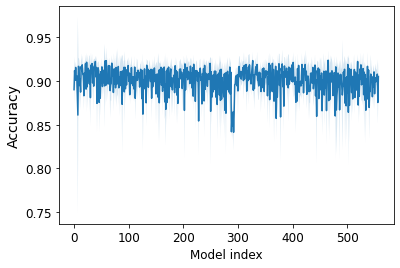

In [229]:
ax = plot_score(results)
ax.set_xlabel('Model index')
ax.set_ylabel('Accuracy', fontsize=14)
plt.show()

In [230]:
for name, pair in zip(name_sets,X_y_sets):
    measures = best_model_full.model.evaluate(*pair, verbose = 0)
    loss, acc = np.around(measures, 5)
    print(f'Loss = {loss}, Accuracy = {acc}, Dataset = {name}')

Loss = 0.27487, Accuracy = 0.90383, Dataset = (X_train, y_train_onehot)
Loss = 0.56835, Accuracy = 0.79336, Dataset = (X_test, y_test_onehot)
Loss = 0.27881, Accuracy = 0.90119, Dataset = (X_tr, y_tr)
Loss = 0.25912, Accuracy = 0.91441, Dataset = (X_valid, y_valid)


### Hyperparameter tuning with dropout regularization and power scheduling for SGD

***Power Scheduling*** \
`lr = lr0 / (1 + steps / s)**c`

Keras uses `c=1` and `s = 1 / decay` \

After s steps, it is down to lr0 / 2. After s more steps, it is down to lr0 / 3

In [75]:
def mpl_1_hidden(h_layer_neurons = 18, n_features = 23, opt = None,
                 activation = 'relu', init = 'glorot_uniform'):
    if activation == 'selu':
        drop = AlphaDropout(0.2)
    else: 
        drop = Dropout(0.2)    
    model = Sequential([
        Input(shape = (n_features,)),
        Dense(h_layer_neurons, activation = activation,
              kernel_initializer = init),
        drop,
        Dense(5, activation = 'softmax')
    ])
    loss = 'categorical_crossentropy'
    if opt == sgd:
        opt = opt(learning_rate=0.5, momentum=0.9, 
                        nesterov=True, decay=1e-2)
    else:
        opt = opt(learning_rate = 0.01)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

In [76]:
params1 = {'activation': ['relu','tanh','elu'],
          'init': ['he_normal','he_uniform'],
          'h_layer_neurons': [7, 10, 12, 14, 18, 23, 40, 46],
          'opt': [rmsprop, nadam, sgd]
}


params2 = {'h_layer_neurons': [7, 10, 12, 14, 18, 23, 40, 46],
           'activation': ['selu'], 'init': ['lecun_normal'],
           'opt': [rmsprop, nadam, sgd]
}



param_list = [params1, params2]

In [77]:
mlp1_full = KerasClassifier(mpl_1_hidden)

In [78]:
gridsearch_full = GridSearchCV(mlp1_full, param_list, cv = 5, n_jobs = -1)

In [79]:
stop = EarlyStopping(patience = 10)
gridsearch_full.fit(X_tr, y_tr, callbacks = [stop], epochs = 100,
               validation_data = (X_valid, y_valid))

Epoch 1/100
148/148 [==============================] - 0s 987us/step - loss: 0.5872 - accuracy: 0.7837 - val_loss: 0.2804 - val_accuracy: 0.8924
Epoch 2/100
148/148 [==============================] - 0s 487us/step - loss: 0.2985 - accuracy: 0.8815 - val_loss: 0.2619 - val_accuracy: 0.9042
Epoch 3/100
148/148 [==============================] - 0s 487us/step - loss: 0.2553 - accuracy: 0.8944 - val_loss: 0.2431 - val_accuracy: 0.9068
Epoch 4/100
148/148 [==============================] - 0s 480us/step - loss: 0.2327 - accuracy: 0.9037 - val_loss: 0.1917 - val_accuracy: 0.9178
Epoch 5/100
148/148 [==============================] - 0s 480us/step - loss: 0.2167 - accuracy: 0.9114 - val_loss: 0.1902 - val_accuracy: 0.9229
Epoch 6/100
148/148 [==============================] - 0s 467us/step - loss: 0.2064 - accuracy: 0.9165 - val_loss: 0.1623 - val_accuracy: 0.9331
Epoch 7/100
148/148 [==============================] - 0s 473us/step - loss: 0.1921 - accuracy: 0.9203 - val_loss: 0.1604 - val_ac

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001E0C301F430>,
             n_jobs=-1,
             param_grid=[{'activation': ['relu', 'tanh', 'elu'],
                          'h_layer_neurons': [7, 10, 12, 14, 18, 23, 40, 46],
                          'init': ['he_normal', 'he_uniform'],
                          'opt': [<class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>,
                                  <class 'tensorflow.python.ker...
                                  <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>]},
                         {'activation': ['selu'],
                          'h_layer_neurons': [7, 10, 12, 14, 18, 23, 40, 46],
                          'init': ['lecun_normal'],
                          'opt': [<class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>,
                                  <class 'tensorflow.python.keras.optimizer_v2.nadam.N

In [80]:
gridsearch_full.best_params_

{'activation': 'relu',
 'h_layer_neurons': 40,
 'init': 'he_uniform',
 'opt': tensorflow.python.keras.optimizer_v2.nadam.Nadam}

In [81]:
gridsearch_full.best_score_

0.945502769947052

In [82]:
best_model_full = gridsearch_full.best_estimator_

In [83]:
best_model_full_history = best_model_full.model.history.history

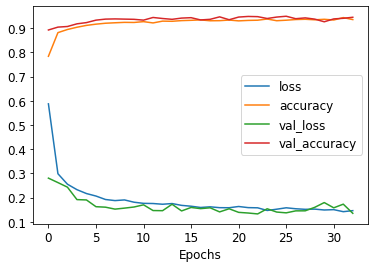

In [84]:
pd.DataFrame(best_model_full_history).plot(figsize=(6, 4))
plt.xlabel('Epochs')
plt.show()

Also in this case, the model does not seem to overfit over the train set. Again, the model reach the early stop before to run all the epochs.

In [85]:
results = gridsearch_full.cv_results_

In [104]:
report(results, 3)

Model with rank: 1
Mean validation score: 0.922 (std: 0.011)
Parameters: {'activation': 'relu', 'h_layer_neurons': 18, 'init': 'he_uniform', 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}

Model with rank: 2
Mean validation score: 0.922 (std: 0.007)
Parameters: {'activation': 'relu', 'h_layer_neurons': 40, 'init': 'he_uniform', 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}

Model with rank: 3
Mean validation score: 0.920 (std: 0.007)
Parameters: {'activation': 'relu', 'h_layer_neurons': 12, 'init': 'he_uniform', 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}



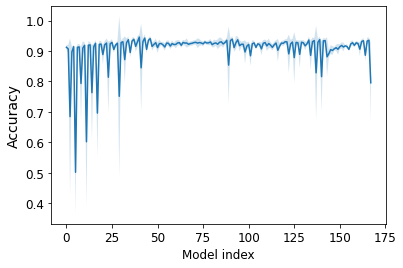

In [87]:
ax = plot_score(results)
ax.set_xlabel('Model index')
ax.set_ylabel('Accuracy', fontsize=14)
plt.show()

In [88]:
for name, pair in zip(name_sets,X_y_sets):
    measures = best_model_full.model.evaluate(*pair, verbose = 0)
    loss, acc = np.around(measures, 5)
    print(f'Loss = {loss}, Accuracy = {acc}, Dataset = {name}')

Loss = 0.12223, Accuracy = 0.952, Dataset = (X_train, y_train_onehot)
Loss = 0.52954, Accuracy = 0.83983, Dataset = (X_test, y_test_onehot)
Loss = 0.11902, Accuracy = 0.95377, Dataset = (X_tr, y_tr)
Loss = 0.13506, Accuracy = 0.94492, Dataset = (X_valid, y_valid)


### Hyperparameter tuning with L2 regularization and power scheduling for SGD

In [90]:
def mpl_1_hidden(h_layer_neurons = 18, n_features = 23, opt = None,
                 activation = 'relu', init = 'glorot_uniform'):   
    model = Sequential([
        Input(shape = (n_features,)),
        Dense(h_layer_neurons, activation = activation,
              kernel_initializer = init,
              kernel_regularizer=l2(0.01)),    
        Dense(5, activation = 'softmax')
    ])
    loss = 'categorical_crossentropy'
    if opt == sgd:
        opt = opt(learning_rate=0.5, momentum=0.9, 
                        nesterov=True, decay=1e-2)
    else:
        opt = opt(learning_rate = 0.01)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

In [91]:
params1 = {'activation': ['relu','tanh','elu'],
          'init': ['he_normal','he_uniform'],
          'h_layer_neurons': [7, 10, 12, 14, 18, 23, 40, 46],
          'opt': [rmsprop, nadam, sgd]
}


params2 = {'h_layer_neurons': [7, 10, 12, 14, 18, 23, 40, 46],
           'activation': ['selu'], 'init': ['lecun_normal'],
           'opt': [rmsprop, nadam, sgd]
}



param_list = [params1, params2]

In [92]:
mlp1_full = KerasClassifier(mpl_1_hidden)

In [93]:
gridsearch_full = GridSearchCV(mlp1_full, param_list, cv = 5, n_jobs = -1)

In [94]:
stop = EarlyStopping(patience = 10)
gridsearch_full.fit(X_tr, y_tr, callbacks = [stop], epochs = 100,
               validation_data = (X_valid, y_valid))

Epoch 1/100
148/148 [==============================] - 0s 974us/step - loss: 0.9367 - accuracy: 0.7604 - val_loss: 0.5789 - val_accuracy: 0.8754
Epoch 2/100
148/148 [==============================] - 0s 440us/step - loss: 0.5213 - accuracy: 0.8738 - val_loss: 0.5028 - val_accuracy: 0.8856
Epoch 3/100
148/148 [==============================] - 0s 413us/step - loss: 0.4510 - accuracy: 0.8866 - val_loss: 0.4921 - val_accuracy: 0.8525
Epoch 4/100
148/148 [==============================] - 0s 426us/step - loss: 0.4201 - accuracy: 0.8878 - val_loss: 0.3778 - val_accuracy: 0.9042
Epoch 5/100
148/148 [==============================] - 0s 453us/step - loss: 0.3995 - accuracy: 0.8866 - val_loss: 0.6179 - val_accuracy: 0.7483
Epoch 6/100
148/148 [==============================] - 0s 433us/step - loss: 0.3809 - accuracy: 0.8919 - val_loss: 0.3462 - val_accuracy: 0.9127
Epoch 7/100
148/148 [==============================] - 0s 413us/step - loss: 0.3760 - accuracy: 0.8836 - val_loss: 0.3412 - val_ac

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001E0C36F67F0>,
             n_jobs=-1,
             param_grid=[{'activation': ['relu', 'tanh', 'elu'],
                          'h_layer_neurons': [7, 10, 12, 14, 18, 23, 40, 46],
                          'init': ['he_normal', 'he_uniform'],
                          'opt': [<class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>,
                                  <class 'tensorflow.python.ker...
                                  <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>]},
                         {'activation': ['selu'],
                          'h_layer_neurons': [7, 10, 12, 14, 18, 23, 40, 46],
                          'init': ['lecun_normal'],
                          'opt': [<class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>,
                                  <class 'tensorflow.python.keras.optimizer_v2.nadam.N

In [95]:
gridsearch_full.best_params_

{'activation': 'relu',
 'h_layer_neurons': 18,
 'init': 'he_uniform',
 'opt': tensorflow.python.keras.optimizer_v2.nadam.Nadam}

In [96]:
gridsearch_full.best_score_

0.921753716468811

In [97]:
best_model_full = gridsearch_full.best_estimator_

In [98]:
best_model_full_history = best_model_full.model.history.history

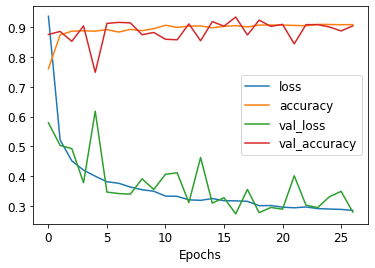

In [99]:
pd.DataFrame(best_model_full_history).plot(figsize=(6, 4))
plt.xlabel('Epochs')
plt.show()

Also in this case, the model does not seem to overfit over the train set. Again, the model reach the early stop before to run all the epochs.

In [100]:
results = gridsearch_full.cv_results_

In [101]:
report(results, 50)

Model with rank: 1
Mean validation score: 0.922 (std: 0.011)
Parameters: {'activation': 'relu', 'h_layer_neurons': 18, 'init': 'he_uniform', 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}

Model with rank: 2
Mean validation score: 0.922 (std: 0.007)
Parameters: {'activation': 'relu', 'h_layer_neurons': 40, 'init': 'he_uniform', 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}

Model with rank: 3
Mean validation score: 0.920 (std: 0.007)
Parameters: {'activation': 'relu', 'h_layer_neurons': 12, 'init': 'he_uniform', 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}

Model with rank: 4
Mean validation score: 0.920 (std: 0.011)
Parameters: {'activation': 'tanh', 'h_layer_neurons': 23, 'init': 'he_uniform', 'opt': <class 'tensorflow.python.keras.optimizer_v2.nadam.Nadam'>}

Model with rank: 5
Mean validation score: 0.919 (std: 0.011)
Parameters: {'activation': 'relu', 'h_layer_neurons': 10, 'init': 'he_normal', 'opt': <class 'tensorflo

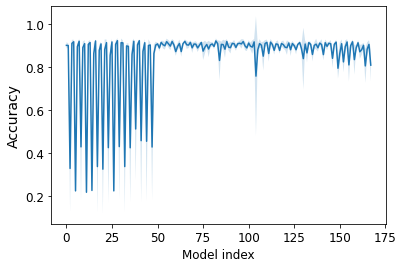

In [102]:
ax = plot_score(results)
ax.set_xlabel('Model index')
ax.set_ylabel('Accuracy', fontsize=14)
plt.show()

In [103]:
for name, pair in zip(name_sets,X_y_sets):
    measures = best_model_full.model.evaluate(*pair, verbose = 0)
    loss, acc = np.around(measures, 5)
    print(f'Loss = {loss}, Accuracy = {acc}, Dataset = {name}')

Loss = 0.30648, Accuracy = 0.88891, Dataset = (X_train, y_train_onehot)
Loss = 0.52153, Accuracy = 0.81826, Dataset = (X_test, y_test_onehot)
Loss = 0.31326, Accuracy = 0.88507, Dataset = (X_tr, y_tr)
Loss = 0.27938, Accuracy = 0.90424, Dataset = (X_valid, y_valid)


### Best parameters with different batch sizes

In [176]:
def mpl_1_hidden(h_layer_neurons = 18, n_features = 23, opt = None,
                 activation = 'relu', init = 'glorot_uniform'):   
    model = Sequential([
        Input(shape = (n_features,)),
        Dense(h_layer_neurons, activation = activation,
              kernel_initializer = init),    
        Dense(5, activation = 'softmax')
    ])
    loss = 'categorical_crossentropy'
    if opt == sgd:
        opt = opt(learning_rate=0.5, momentum=0.9, 
                        nesterov=True, decay=1e-2)
    else:
        opt = opt(learning_rate = 0.01)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

In [185]:
# let's see how results change with different batch sizes

n_rows = X_train.shape[0]
batch_size_lst = [2**n for n in range(12)] + [n_rows//2, n_rows]
loss_train = []
loss_test = []
acc_train = []
acc_test = []
data_set_names = ['train', 'test']

for batch in batch_size_lst:
    model = mpl_1_hidden(activation = 'relu', h_layer_neurons = 18,
                         init = 'he_uniform', opt = nadam)        
    model.fit(X_train, y_train_onehot, epochs = 100, 
              batch_size = batch, verbose = 0)    
    for i, pair in enumerate(X_y_sets[:2]):
        X, y = pair
        measures = model.evaluate(X, y, verbose = 0)
        loss, acc = np.around(measures, 5)
        if data_set_names[i] == 'train':
            loss_train.append(loss)
            acc_train.append(acc)
        else:
            loss_test.append(loss)
            acc_test.append(acc)           

In [186]:
results_df = pd.DataFrame({
                            'loss_train': loss_train,
                            'loss_test': loss_test,
                            'acc_train': acc_train,
                            'acc_test': acc_test,
}, index = batch_size_lst)
results_df.index.name = 'batch_size'

In [187]:
results_df

,loss_train,loss_test,acc_train,acc_test
batch_size,,,,
1,0.15296,1.59089,0.94640,0.78257
2,0.14030,1.15490,0.93945,0.82324
4,0.11862,1.23312,0.95302,0.82407
8,0.08746,1.10091,0.96099,0.83693
16,0.13413,1.30768,0.94454,0.81701
32,0.09224,1.12623,0.95896,0.81743
64,0.19383,1.24573,0.92317,0.79087
128,0.11699,0.61839,0.94997,0.83485
256,0.24891,0.70925,0.90383,0.79959


It seems that for $\mathtt{batch\_size} = 2^{10}$ and $\mathtt{batch\_size} = 2^{11}$, on the test set, the model has an higher accuracy and a smaller loss on the validation set, thus the model generalize better.

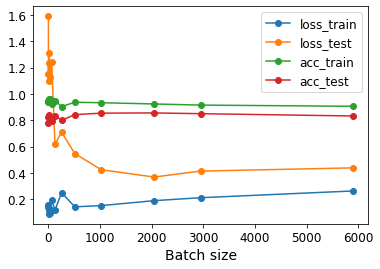

In [239]:
results_df.plot(style = '-o', figsize = (6,4))
plt.xlabel('Batch size', fontsize = 14)
plt.show()

For this reason we decided to perform a last hyperparameter tuning using `batch_size = 2048`

---

In [26]:
def mpl_1_hidden(h_layer_neurons = 18, n_features = 23, opt = None,
                 activation = 'relu', init = 'glorot_uniform', 
                 lr = 0.01, reg: '{None, (reg_type, rate)}' = None,
                 momentum = None, decay=1e-2):   
    model = Sequential()
    model.add(Input(shape = (n_features,)))
    if reg is None or reg[0] == l2:
        model.add(Dense(h_layer_neurons, activation = activation,
                  kernel_initializer = init, 
                  kernel_regularizer = reg))
    else:
        drop, rate = reg
        model.add(drop(rate))
        model.add(Dense(h_layer_neurons, activation = activation,
                  kernel_initializer = init))  
        model.add(drop(rate))
    model.add(Dense(5, activation = 'softmax'))    
    loss = 'categorical_crossentropy'
    if opt == sgd:
        opt = opt(learning_rate=lr, momentum=momentum, 
                        nesterov=True, decay=decay)
    else:
        opt = opt(learning_rate = lr)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

In [261]:
params1 = {'activation': ['relu','tanh','elu'],
          'init': ['he_uniform'],
          'h_layer_neurons': [3,5,8,14,21,34,40,46],
          'opt': [rmsprop, nadam],
          'lr': [0.01, 0.0075, 0.005, 0.0025, 0.001],
          'reg': [None] + [(Dropout, n) for n in [.2,.5]] + [(l2, n) for n in [0.01, 0.005]]
          }


params2 = {'h_layer_neurons': [3,5,8,14,21,34,40,46],
           'activation': ['selu'], 'init': ['lecun_normal'],
           'opt': [rmsprop, nadam],
           'lr': [0.01, 0.0075, 0.005, 0.0025, 0.001],
           'reg': [None] + [(AlphaDropout, n) for n in [.2,.5]] + [(l2, n) for n in [0.01, 0.005]]
          }

params3 = {'activation': ['relu','tanh','elu'],
          'init': ['he_uniform'],
          'h_layer_neurons': [3,5,8,14,21,34,40,46],
          'opt': [sgd],
          'lr': [0.5, 0.3, 0.1, 0.05, 0.01],
          'reg': [None] + [(Dropout, n) for n in [.2,.5]] + [(l2, n) for n in [0.01, 0.005]],
          'momentum': [0.9, 0.7, 0.5]
          }

params4 = {'h_layer_neurons': [3,5,8,14,21,34,40,46],
           'activation': ['selu'], 'init': ['lecun_normal'],
           'opt': [sgd],
           'lr': [0.5, 0.3, 0.1, 0.05, 0.01],
           'reg': [None] + [(AlphaDropout, n) for n in [.2,.5]] + [(l2, n) for n in [0.01, 0.005]],
           'momentum': [0.9, 0.7, 0.5]
          }

param_list = [params1, params2, params3, params4]

In [262]:
mlp1_full = KerasClassifier(mpl_1_hidden, verbose=0)

In [263]:
gridsearch_full = GridSearchCV(mlp1_full, param_list, cv = 3)

In [264]:
# DO NOT RUN THIS, IT TAKES HOURS!

# stop = EarlyStopping(patience = 10)
# gridsearch_full.fit(X_tr, y_tr, callbacks = [stop], epochs = 100,
#                     validation_data = (X_valid, y_valid), 
#                     batch_size = 2048)

In [265]:
gridsearch_full.best_params_

{'activation': 'relu',
 'h_layer_neurons': 40,
 'init': 'he_uniform',
 'lr': 0.3,
 'momentum': 0.9,
 'opt': tensorflow.python.keras.optimizer_v2.gradient_descent.SGD,
 'reg': None}

In [266]:
results = gridsearch_full.cv_results_

In [300]:
report(results, 68)

Model with rank: 1
Mean validation score: 0.928 (std: 0.004)
Parameters: {'activation': 'relu', 'h_layer_neurons': 40, 'init': 'he_uniform', 'lr': 0.3, 'momentum': 0.9, 'opt': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>, 'reg': None}

Model with rank: 2
Mean validation score: 0.925 (std: 0.009)
Parameters: {'activation': 'tanh', 'h_layer_neurons': 40, 'init': 'he_uniform', 'lr': 0.3, 'momentum': 0.9, 'opt': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>, 'reg': None}

Model with rank: 3
Mean validation score: 0.925 (std: 0.009)
Parameters: {'activation': 'elu', 'h_layer_neurons': 40, 'init': 'he_uniform', 'lr': 0.3, 'momentum': 0.9, 'opt': <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>, 'reg': None}

Model with rank: 4
Mean validation score: 0.924 (std: 0.003)
Parameters: {'activation': 'tanh', 'h_layer_neurons': 14, 'init': 'he_uniform', 'lr': 0.5, 'momentum': 0.9, 'opt': <class 'tensorflow.python.keras.optimizer_v2.gra

In [272]:
best_model_full = gridsearch_full.best_estimator_

In [273]:
best_model_full_history = best_model_full.model.history.history

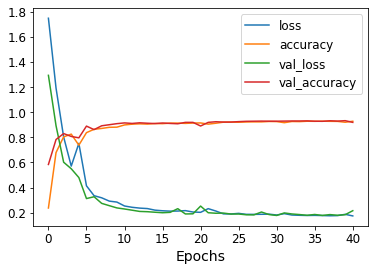

In [274]:
pd.DataFrame(best_model_full_history).plot(figsize=(6, 4))
plt.xlabel('Epochs', fontsize = 14)
plt.show()

Also in this case, the model does not seem to overfit over the train set. Again, the model reach the early stop before to run all the epochs.

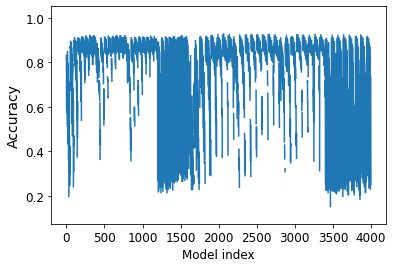

In [275]:
ax = plot_score(results)
ax.set_xlabel('Model index')
ax.set_ylabel('Accuracy', fontsize=14)
plt.show()

In [276]:
for name, pair in zip(name_sets,X_y_sets):
    measures = best_model_full.model.evaluate(*pair, verbose = 0)
    loss, acc = np.around(measures, 5)
    print(f'Loss = {loss}, Accuracy = {acc}, Dataset = {name}')

Loss = 0.19752, Accuracy = 0.92249, Dataset = (X_train, y_train_onehot)
Loss = 0.37628, Accuracy = 0.85892, Dataset = (X_test, y_test_onehot)
Loss = 0.19288, Accuracy = 0.92345, Dataset = (X_tr, y_tr)
Loss = 0.21606, Accuracy = 0.91864, Dataset = (X_valid, y_valid)


In [674]:
# let's train the best model on the full train set

mlp_best = mpl_1_hidden(h_layer_neurons=40, opt=sgd, activation='relu', 
                     lr=0.3, momentum=0.9, init='he_uniform')
# stop = EarlyStopping(patience = 10, min_delta=0.)
mlp_best.fit(X_train, y_train_onehot, batch_size=2048, epochs=1000, 
          verbose=1)#, validation_split=0.1, callbacks=[stop])

print()
for name, pair in zip(name_sets,X_y_sets):
    measures = mlp_best.evaluate(*pair, verbose = 0)
    loss, acc = np.around(measures, 5)
    print(f'Loss = {loss}, Accuracy = {acc}, Dataset = {name}')

Epoch 1/1000
3/3 [==============================] - 0s 2ms/step - loss: 1.4493 - accuracy: 0.4084
Epoch 2/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.9590 - accuracy: 0.7149
Epoch 3/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.6493 - accuracy: 0.8270
Epoch 4/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.9287 - accuracy: 0.7096
Epoch 5/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.5998 - accuracy: 0.7359
Epoch 6/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3552 - accuracy: 0.8723
Epoch 7/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.3177 - accuracy: 0.8781
Epoch 8/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.2857 - accuracy: 0.8894
Epoch 9/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.2639 - accuracy: 0.8937
Epoch 10/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.2507 - accuracy: 0.9001
Epoch 11/1000
3/3 [

3/3 [==============================] - 0s 2ms/step - loss: 0.1499 - accuracy: 0.9366
Epoch 166/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1501 - accuracy: 0.9374
Epoch 167/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1505 - accuracy: 0.9344
Epoch 168/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1498 - accuracy: 0.9369
Epoch 169/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1499 - accuracy: 0.9366
Epoch 170/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1495 - accuracy: 0.9378
Epoch 171/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1494 - accuracy: 0.9376
Epoch 172/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9362
Epoch 173/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9371
Epoch 174/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1491 - accuracy: 0.9372
Epoch 175/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.1443 - accuracy: 0.9384
Epoch 248/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1441 - accuracy: 0.9396
Epoch 249/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1439 - accuracy: 0.9383
Epoch 250/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1440 - accuracy: 0.9376
Epoch 251/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1438 - accuracy: 0.9379
Epoch 252/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1436 - accuracy: 0.9384
Epoch 253/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1436 - accuracy: 0.9388
Epoch 254/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1438 - accuracy: 0.9379
Epoch 255/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1439 - accuracy: 0.9379
Epoch 256/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1435 - accuracy: 0.9378
Epoch 257/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.1398 - accuracy: 0.9389
Epoch 330/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1398 - accuracy: 0.9393
Epoch 331/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1397 - accuracy: 0.9389
Epoch 332/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1397 - accuracy: 0.9400
Epoch 333/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1398 - accuracy: 0.9393
Epoch 334/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1396 - accuracy: 0.9401
Epoch 335/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1397 - accuracy: 0.9405
Epoch 336/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1395 - accuracy: 0.9395
Epoch 337/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1396 - accuracy: 0.9393
Epoch 338/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1398 - accuracy: 0.9391
Epoch 339/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.1368 - accuracy: 0.9418
Epoch 412/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1368 - accuracy: 0.9425
Epoch 413/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1367 - accuracy: 0.9417
Epoch 414/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.9423
Epoch 415/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.9418
Epoch 416/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.9420
Epoch 417/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9422
Epoch 418/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9425
Epoch 419/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9427
Epoch 420/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1364 - accuracy: 0.9417
Epoch 421/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.9435
Epoch 494/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1343 - accuracy: 0.9432
Epoch 495/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1342 - accuracy: 0.9432
Epoch 496/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9435
Epoch 497/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9435
Epoch 498/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9435
Epoch 499/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9434
Epoch 500/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9427
Epoch 501/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9439
Epoch 502/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.9437
Epoch 503/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.9442
Epoch 576/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1322 - accuracy: 0.9437
Epoch 577/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1324 - accuracy: 0.9440
Epoch 578/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1322 - accuracy: 0.9444
Epoch 579/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1322 - accuracy: 0.9440
Epoch 580/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.9440
Epoch 581/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.9442
Epoch 582/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.9440
Epoch 583/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.9439
Epoch 584/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1320 - accuracy: 0.9442
Epoch 585/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.1306 - accuracy: 0.9447
Epoch 658/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1306 - accuracy: 0.9444
Epoch 659/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1306 - accuracy: 0.9442
Epoch 660/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1309 - accuracy: 0.9445
Epoch 661/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1306 - accuracy: 0.9445
Epoch 662/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1306 - accuracy: 0.9440
Epoch 663/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1305 - accuracy: 0.9445
Epoch 664/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1305 - accuracy: 0.9449
Epoch 665/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1305 - accuracy: 0.9449
Epoch 666/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1304 - accuracy: 0.9447
Epoch 667/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.1293 - accuracy: 0.9452
Epoch 740/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9454
Epoch 741/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9456
Epoch 742/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9456
Epoch 743/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9456
Epoch 744/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9456
Epoch 745/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9452
Epoch 746/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9450
Epoch 747/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9454
Epoch 748/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1292 - accuracy: 0.9457
Epoch 749/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.9462
Epoch 822/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.9461
Epoch 823/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.9461
Epoch 824/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.9464
Epoch 825/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.9464
Epoch 826/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.9461
Epoch 827/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.9462
Epoch 828/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.9464
Epoch 829/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.9464
Epoch 830/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.9462
Epoch 831/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.9467
Epoch 904/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.9466
Epoch 905/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.9464
Epoch 906/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.9466
Epoch 907/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.9466
Epoch 908/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.9461
Epoch 909/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.9464
Epoch 910/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.9464
Epoch 911/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.9467
Epoch 912/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1270 - accuracy: 0.9466
Epoch 913/1000


3/3 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9474
Epoch 986/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9471
Epoch 987/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1263 - accuracy: 0.9473
Epoch 988/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9474
Epoch 989/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9471
Epoch 990/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9473
Epoch 991/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9473
Epoch 992/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1261 - accuracy: 0.9476
Epoch 993/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1261 - accuracy: 0.9474
Epoch 994/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9474
Epoch 995/1000


This time the results of the best model seems acceptable. However, the results of a neural network may change alot every time the model is executed due to random weights inizialization.

In [281]:
# let's use the best model with 14 neurons (rank #4)

mlp14 = mpl_1_hidden(h_layer_neurons=14, opt=sgd, activation='tanh', 
                     lr=0.5, momentum=0.9, init='he_uniform')

mlp14.fit(X_train, y_train_onehot, batch_size=2048, epochs=100, 
          verbose=0)

for name, pair in zip(name_sets,X_y_sets):
    measures = mlp14.evaluate(*pair, verbose = 0)
    loss, acc = np.around(measures, 5)
    print(f'Loss = {loss}, Accuracy = {acc}, Dataset = {name}')

Loss = 0.15315, Accuracy = 0.93708, Dataset = (X_train, y_train_onehot)
Loss = 0.37424, Accuracy = 0.85975, Dataset = (X_test, y_test_onehot)
Loss = 0.15412, Accuracy = 0.93554, Dataset = (X_tr, y_tr)
Loss = 0.14927, Accuracy = 0.94322, Dataset = (X_valid, y_valid)


In [289]:
# let's use the best model with 5 neurons (rank #16)

mlp5 = mpl_1_hidden(h_layer_neurons=5, opt=sgd, activation='tanh', 
                     lr=0.5, momentum=0.9, init='he_uniform')

mlp5.fit(X_train, y_train_onehot, batch_size=2048, epochs=100, 
          verbose=0)

for name, pair in zip(name_sets,X_y_sets):
    measures = mlp5.evaluate(*pair, verbose = 0)
    loss, acc = np.around(measures, 5)
    print(f'Loss = {loss}, Accuracy = {acc}, Dataset = {name}')

Loss = 0.16731, Accuracy = 0.92944, Dataset = (X_train, y_train_onehot)
Loss = 0.39064, Accuracy = 0.86017, Dataset = (X_test, y_test_onehot)
Loss = 0.16834, Accuracy = 0.92897, Dataset = (X_tr, y_tr)
Loss = 0.16319, Accuracy = 0.93136, Dataset = (X_valid, y_valid)


In [292]:
# let's use the best model with 8 neurons (rank #17)

mlp8 = mpl_1_hidden(h_layer_neurons=8, opt=sgd, activation='tanh', 
                     lr=0.5, momentum=0.9, init='he_uniform')

mlp8.fit(X_train, y_train_onehot, batch_size=2048, epochs=100, 
          verbose=0)

for name, pair in zip(name_sets,X_y_sets):
    measures = mlp8.evaluate(*pair, verbose = 0)
    loss, acc = np.around(measures, 5)
    print(f'Loss = {loss}, Accuracy = {acc}, Dataset = {name}')

Loss = 0.18765, Accuracy = 0.92045, Dataset = (X_train, y_train_onehot)
Loss = 0.40141, Accuracy = 0.84979, Dataset = (X_test, y_test_onehot)
Loss = 0.18998, Accuracy = 0.91858, Dataset = (X_tr, y_tr)
Loss = 0.17835, Accuracy = 0.92797, Dataset = (X_valid, y_valid)


In [299]:
# let's use the best model with 3 neurons (rank #68)

mlp3 = mpl_1_hidden(h_layer_neurons=3, opt=sgd, activation='tanh', 
                     lr=0.5, momentum=0.9, init='he_uniform')

mlp3.fit(X_train, y_train_onehot, batch_size=2048, epochs=100, 
          verbose=0)

for name, pair in zip(name_sets,X_y_sets):
    measures = mlp3.evaluate(*pair, verbose = 0)
    loss, acc = np.around(measures, 5)
    print(f'Loss = {loss}, Accuracy = {acc}, Dataset = {name}')

Loss = 0.21757, Accuracy = 0.90621, Dataset = (X_train, y_train_onehot)
Loss = 0.47029, Accuracy = 0.83278, Dataset = (X_test, y_test_onehot)
Loss = 0.2228, Accuracy = 0.90204, Dataset = (X_tr, y_tr)
Loss = 0.19668, Accuracy = 0.92288, Dataset = (X_valid, y_valid)


### Keras vs Scikit-learn

The best model use parameters that are also aviable for the sklearn MLPClassifier, thus we can run the optimal model also there and see the differences. (Actually, sklearn does not allow to set the initialization mode. Moreover, the learning rate scheduling `invscaling` is not identical to the power scheduling of keras).

In [680]:
sk_best_clf = MLPClassifier(hidden_layer_sizes=(40,),
                            activation = 'relu',
                            solver = 'sgd',
                            alpha = 0,
                            batch_size = 2048,
                            learning_rate = 'invscaling',
                            learning_rate_init = 0.3,
                            max_iter = 1500,
                            momentum = 0.9,
                            nesterovs_momentum = True,
                            validation_fraction=0.,
                            power_t = 0.50 # default
                            )

In [681]:
sk_best_clf.fit(X_train, y_train.values)

MLPClassifier(alpha=0, batch_size=2048, hidden_layer_sizes=(40,),
              learning_rate='invscaling', learning_rate_init=0.3, max_iter=1500,
              solver='sgd', validation_fraction=0.0)

In [682]:
sk_best_clf.score(X_test, y_test.values)

0.8340248962655602

In [683]:
sk_best_clf.best_loss_

0.5718879105020879

In [684]:
sk_best_clf.loss_

0.5718879105020879

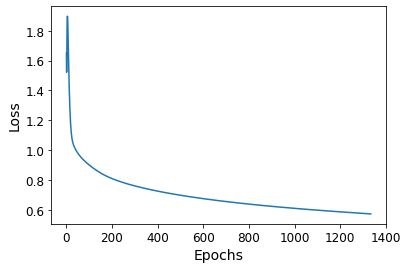

In [685]:
plt.figure(figsize=(6,4))
plt.plot(sk_best_clf.loss_curve_)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.show()

The two libraries have different results. Particularly, sklearn is slower and converges around 700-1200 epochs dipending on initialization, whereas keras converge after 45/50 epochs. Moreover sklearn prduce an higher loss and a lower accuracy. However, changing the `power_t` parameter the performance of sklearn increase significantly obtaining an accuracy very similar to keras and even a better loss. Moreover, it requires fewer epochs to converge.

In [168]:
sk_best_clf = MLPClassifier(hidden_layer_sizes=(40,),
                            activation = 'relu',
                            solver = 'sgd',
                            alpha = 0,
                            batch_size = 2048,
                            learning_rate = 'invscaling',
                            learning_rate_init = 0.3,
                            max_iter = 1500,
                            momentum = 0.9,
                            nesterovs_momentum = True,
                            validation_fraction=0.,
                            power_t = 0.1)

In [169]:
sk_best_clf.fit(X_train, y_train.values)

MLPClassifier(alpha=0, batch_size=2048, hidden_layer_sizes=(40,),
              learning_rate='invscaling', learning_rate_init=0.3, max_iter=1500,
              power_t=0.1, solver='sgd', validation_fraction=0.0)

In [170]:
sk_best_clf.score(X_test, y_test.values)

0.866390041493776

In [171]:
sk_best_clf.best_loss_

0.14165165722533216

In [172]:
sk_best_clf.loss_

0.15058109008523343

In [178]:
log_loss(y_test, sk_best_clf.predict_proba(X_test))

0.3347270949845726

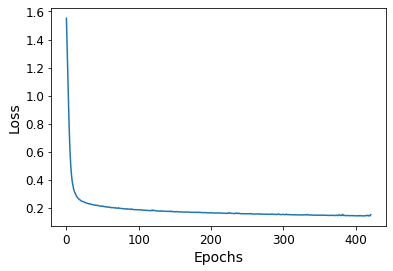

In [173]:
plt.figure(figsize=(6,4))
plt.plot(sk_best_clf.loss_curve_)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.show()

### Decay tuning

In [611]:
def mpl_1_hidden(h_layer_neurons = 18, n_features = 23, opt = None,
                 activation = 'relu', init = 'glorot_uniform', 
                 lr = 0.01, reg: '{None, (reg_type, rate)}' = None,
                 momentum = None, decay=1e-2):   
    model = Sequential()
    model.add(Input(shape = (n_features,)))
    if reg is None or reg[0] == l2:
        model.add(Dense(h_layer_neurons, activation = activation,
                  kernel_initializer = init, 
                  kernel_regularizer = reg))
    else:
        drop, rate = reg
        model.add(drop(rate))
        model.add(Dense(h_layer_neurons, activation = activation,
                  kernel_initializer = init))  
        model.add(drop(rate))
    model.add(Dense(5, activation = 'softmax'))    
    loss = 'sparse_categorical_crossentropy'
    if opt == sgd:
        opt = opt(learning_rate=lr, momentum=momentum, 
                        nesterov=True, decay=decay)
    else:
        opt = opt(learning_rate = lr)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

In [612]:
clf = KerasClassifier(mpl_1_hidden, verbose=0)

In [613]:
decay_lst = [0., 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 
             1e-2, 5e-2, 1e-1, 5e-1,  1.]
params = {'h_layer_neurons': [40], 'opt': [sgd], 'lr': [0.3], 
          'momentum': [0.9], 'init': ['he_uniform'],
          'decay': decay_lst}

In [614]:
gridsearch = GridSearchCV(clf, params, cv = 5,
                          scoring=['accuracy', 'neg_log_loss'],
                          return_train_score=True,
                          refit='accuracy')

In [615]:
stop = EarlyStopping(patience = 10)
gridsearch.fit(X_train, y_train_scaled.values, callbacks=[stop], batch_size=2048, 
               epochs=1000, validation_split=0.1)

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002FEA5719940>,
             param_grid={'decay': [0.0, 1e-06, 5e-06, 1e-05, 5e-05, 0.0001,
                                   0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,
                                   1.0],
                         'h_layer_neurons': [40], 'init': ['he_uniform'],
                         'lr': [0.3], 'momentum': [0.9],
                         'opt': [<class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'neg_log_loss'])

In [616]:
gridsearch.best_params_

{'decay': 0.01,
 'h_layer_neurons': 40,
 'init': 'he_uniform',
 'lr': 0.3,
 'momentum': 0.9,
 'opt': tensorflow.python.keras.optimizer_v2.gradient_descent.SGD}

In [617]:
best_clf = gridsearch.best_estimator_

In [618]:
results = gridsearch.cv_results_

In [624]:
report(results, 8)

,rank_test_accuracy,rank_test_neg_log_loss,mean_test_accuracy,std_test_accuracy,mean_test_neg_log_loss,std_test_neg_log_loss,decay,h_layer_neurons,init,lr,momentum,opt
model_idx,,,,,,,,,,,,
9,1,4,0.890096,0.041349,0.341424,0.136032,0.010000,40,he_uniform,0.3,0.9,<class 'tensorflow.python.keras.optimizer_v2.g...
5,2,3,0.886872,0.042238,0.340162,0.150070,0.000100,40,he_uniform,0.3,0.9,<class 'tensorflow.python.keras.optimizer_v2.g...
2,3,8,0.886024,0.035114,0.364187,0.169594,0.000005,40,he_uniform,0.3,0.9,<class 'tensorflow.python.keras.optimizer_v2.g...
7,4,10,0.885515,0.040421,0.374453,0.180675,0.001000,40,he_uniform,0.3,0.9,<class 'tensorflow.python.keras.optimizer_v2.g...
10,5,2,0.884328,0.037486,0.325799,0.099665,0.050000,40,he_uniform,0.3,0.9,<class 'tensorflow.python.keras.optimizer_v2.g...
11,6,1,0.884328,0.043049,0.318214,0.091067,0.100000,40,he_uniform,0.3,0.9,<class 'tensorflow.python.keras.optimizer_v2.g...
3,7,5,0.877541,0.055013,0.344635,0.179802,0.000010,40,he_uniform,0.3,0.9,<class 'tensorflow.python.keras.optimizer_v2.g...
6,8,6,0.876694,0.039005,0.350023,0.116608,0.000500,40,he_uniform,0.3,0.9,<class 'tensorflow.python.keras.optimizer_v2.g...


In [620]:
results['mean_test_neg_log_loss'] *= -1
results['mean_train_neg_log_loss'] *= -1

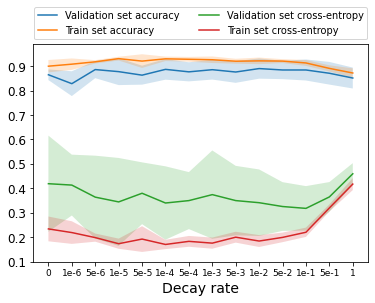

In [621]:
xticks = ['0','1e-6','5e-6','1e-5','5e-5','1e-4','5e-4',
          '1e-3','5e-3','1e-2','5e-2','1e-1','5e-1','1']

ax = plot_score(results, score_name='accuracy')
plot_score(results, score_name='neg_log_loss', ax=ax, legend_name='cross-entropy')
ax.set_xticks(range(len(decay_lst)), xticks)
ax.set_xlabel('Decay rate', fontsize = 14)
plt.xticks(fontsize=9)
plt.legend(loc='lower center', fontsize=9.8, ncol=2,
          bbox_to_anchor = (0, 1, 1, 1))
# plt.savefig('decay_rate_plot.pdf', bbox_inches='tight')
plt.show()

In [622]:
best_clf.model.evaluate(X_test, y_test_scaled, verbose = 0)

[0.3555446267127991, 0.8684647083282471]

In [623]:
best_clf.model.evaluate(X_train, y_train_scaled, verbose = 0)

[0.1771751344203949, 0.9299525022506714]

In [772]:
y_pred = best_clf.model.predict_classes(X_test) + 1 

In [773]:
print(classification_report(y_test, y_pred, 
                      target_names=activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.88      0.98      0.93       496
  WALKING_UPSTAIRS       0.89      0.86      0.87       471
WALKING_DOWNSTAIRS       0.97      0.88      0.92       420
           SITTING       0.83      0.78      0.80       491
          STANDING       0.80      0.85      0.83       532

          accuracy                           0.87      2410
         macro avg       0.87      0.87      0.87      2410
      weighted avg       0.87      0.87      0.87      2410



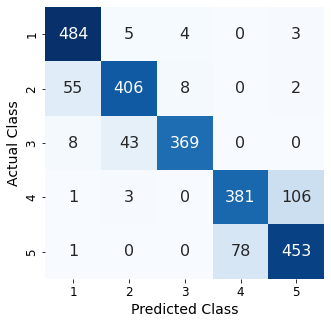

In [774]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_mtx(cm, figsize=(5, 5))
plt.show()

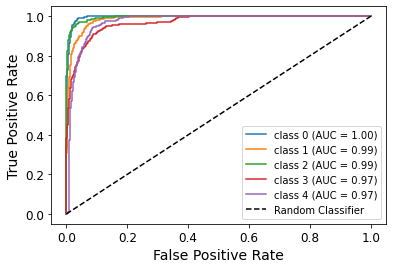

In [775]:
ax = plot_multiclass_roc(best_clf, X_test, y_test_scaled)
ax.legend(fontsize='small')
plt.show()

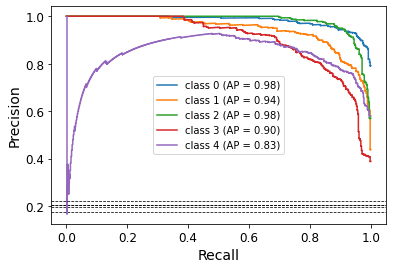

In [776]:
ax = plot_multiclass_prec_rec(best_clf, X_test, y_test_scaled)
ax.legend(fontsize='small')
plt.show()

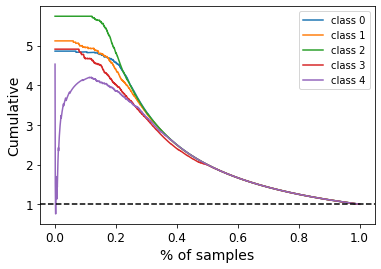

In [777]:
ax = plot_multiclass_lift(best_clf, X_test, y_test_scaled, baseline=True)
ax.legend(fontsize='small')
plt.show()

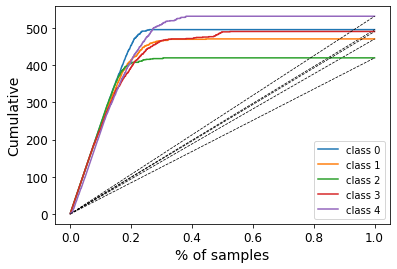

In [778]:
ax = plot_multiclass_gain(best_clf, X_test, y_test_scaled, baseline=True)
ax.legend(fontsize='small')
plt.show()

### Sklearn powert_t tuning

In [345]:
sk_best_clf = MLPClassifier(hidden_layer_sizes=(40,),
                            activation = 'relu',
                            solver = 'sgd',
                            alpha = 0,
                            batch_size = 2048,
                            learning_rate = 'invscaling',
                            learning_rate_init = 0.3,
                            max_iter = 2000,
                            momentum = 0.9,
                            nesterovs_momentum = True,
#                             early_stopping=True,
#                             validation_fraction=0.1
                            )

In [346]:
params = {'power_t': [0.1, 0.2, 0.3, 0.4, 0.5]}
sk_gridsearch = GridSearchCV(sk_best_clf, params, cv =5,
                             scoring=['accuracy', 'neg_log_loss'],
                             refit='accuracy',
                             return_train_score=True)

In [347]:
sk_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0, batch_size=2048,
                                     hidden_layer_sizes=(40,),
                                     learning_rate='invscaling',
                                     learning_rate_init=0.3, max_iter=2000,
                                     solver='sgd'),
             param_grid={'power_t': [0.1, 0.2, 0.3, 0.4, 0.5]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'neg_log_loss'])

In [348]:
sk_gridsearch.best_params_

{'power_t': 0.2}

In [350]:
sk_best_clf = sk_gridsearch.best_estimator_

In [550]:
sk_best_clf.score(X_train, y_train.values)

0.9257123473541384

In [351]:
sk_best_clf.score(X_test, y_test.values)

0.8651452282157677

In [552]:
log_loss(y_train, sk_best_clf.predict_proba(X_train))

0.1822695740302103

In [354]:
log_loss(y_test, sk_best_clf.predict_proba(X_test))

0.35522394512175476

In [469]:
results = sk_gridsearch.cv_results_

In [356]:
for k, v in results.items():
    if 'rank' in k:
        print(k, v)

rank_test_accuracy [2 1 3 4 5]
rank_test_neg_log_loss [3 1 2 4 5]


The best estimator according to the accuracy score is the one with `power_t=0.2`.

In [357]:
results['mean_test_neg_log_loss'] *= -1
results['mean_train_neg_log_loss'] *= -1

In [358]:
results['mean_test_neg_log_loss']

array([0.32807888, 0.30531484, 0.31011921, 0.3633607 , 0.56849313])

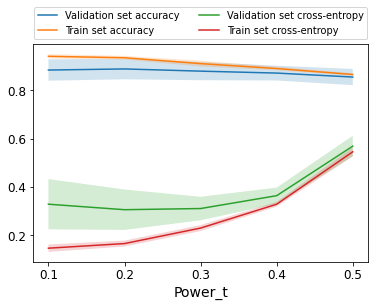

In [479]:
ax = plot_score(results, score_name='accuracy')
plot_score(results, score_name='neg_log_loss', ax=ax,
           legend_name='cross-entropy')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_xticks(range(5),[0.1, 0.2, 0.3, 0.4, 0.5])
plt.legend(loc='lower center', fontsize=9.8, ncol=2,
          bbox_to_anchor = (0, 1, 1, 1))
ax.set_xlabel('Power_t', fontsize=14)
# plt.savefig('power_t_rate_plot.pdf', bbox_inches='tight')
plt.show()

It is very interesting to note that there is a trade-off between the loss in the validation set and the accuracy: smaller values of the `power_t` parameter imply a larger accuracy in both train and validation set but a larger loss in the validation set. This does not occur with the train loss, indeed, reducing the `power_t` value, it continues to decrease monotonically. 

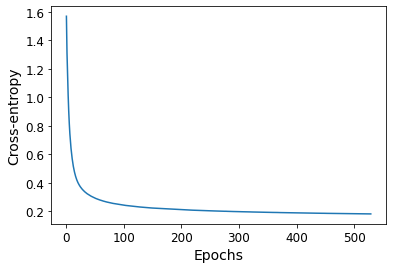

In [480]:
plt.figure(figsize=(6,4))
plt.plot(sk_best_clf.loss_curve_)
plt.xlabel('Epochs', fontsize = 14)
plt.ylabel('Cross-entropy', fontsize = 14)
plt.show()

In [757]:
y_pred = sk_best_clf.predict(X_test)

In [761]:
print(classification_report(y_test, y_pred, 
                      target_names=activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.85      0.99      0.91       496
  WALKING_UPSTAIRS       0.88      0.84      0.86       471
WALKING_DOWNSTAIRS       0.97      0.86      0.91       420
           SITTING       0.85      0.77      0.81       491
          STANDING       0.81      0.87      0.84       532

          accuracy                           0.87      2410
         macro avg       0.87      0.86      0.87      2410
      weighted avg       0.87      0.87      0.86      2410



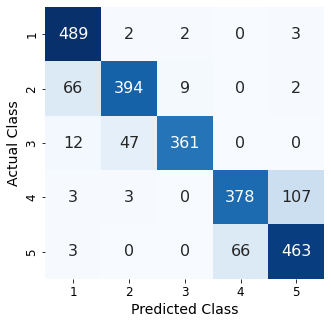

In [762]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_mtx(cm, figsize=(5, 5))
plt.show()

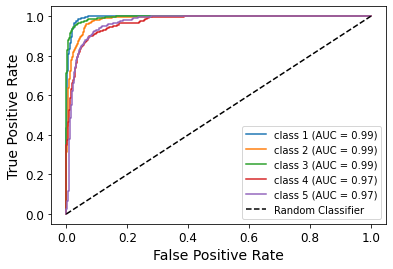

In [767]:
ax = plot_multiclass_roc(sk_best_clf, X_test, y_test)
ax.legend(fontsize='small')
plt.show()

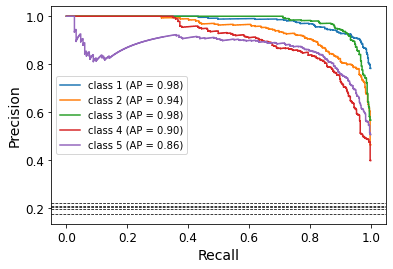

In [764]:
ax = plot_multiclass_prec_rec(sk_best_clf, X_test, y_test)
ax.legend(fontsize='small')
plt.show()

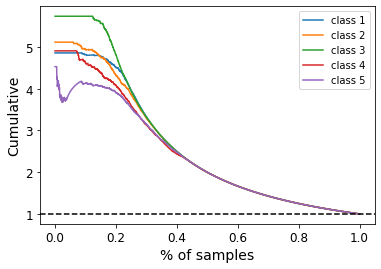

In [765]:
ax = plot_multiclass_lift(sk_best_clf, X_test, y_test, baseline=True)
ax.legend(fontsize='small')
plt.show()

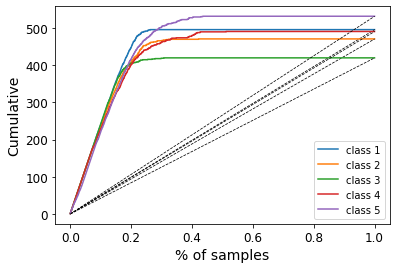

In [766]:
ax = plot_multiclass_gain(sk_best_clf, X_test, y_test, baseline=True)
ax.legend(fontsize='small')
plt.show()

# Multi-Layer Perceptron

In [626]:
def build_mlp(layers=(7,7), n_features=23, activation='relu',
              initializer='he_uniform', opt=sgd, lr=0.3, 
              reg: '{None, "dropout", "l1", "l2"}' = None, 
              reg_rate=0.2, decay=1e-2, momentum=0.9):
    '''
    layers=tuple, where the length of the tuple represents
        the number of hidden layers, whereas the single 
        elements of the tuple represent the numnber of 
        neurons for each layer.
    '''
    
    # input layer
    model = Sequential()
    model.add(Input(shape = (n_features,)))
    
    # hidden layers without any regularization
    if reg is None: 
        for i in range(len(layers)):
            model.add(Dense(layers[i],
                            activation = activation,
                            kernel_initializer = initializer))
            
    # hidden layers with l1 or l2 regularization
    elif reg in {'l1','l2'}:
        penalty = l1 if reg == 'l1' else l2
        for i in range(len(layers)):
            model.add(Dense(layers[i],
                            activation = activation,
                            kernel_initializer = initializer,
                            kernel_regularizer = penalty(reg_rate)))            
            
    # hidden layers with dropout
    else:
        if activation == 'selu':
            drop = AlphaDropout
        else:
            drop = Dropout
        for i in range(len(layers)):
            model.add(drop(reg_rate))
            model.add(Dense(layers[i],
                            activation = activation,
                            kernel_initializer = initializer))
    # output layer              
    model.add(Dense(5, activation = 'softmax'))
                  
    # compile the model
    if opt == sgd:
        opt = opt(learning_rate = lr, momentum = momentum, 
                  nesterov = True, decay = decay)
    else:
        opt = opt(learning_rate = lr)    
    loss = 'sparse_categorical_crossentropy'
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

## Hidden layers and nerurons tuning

In [627]:
layers_tpl = [(10, 20), (40,20), (40,40,20), (40,30,20,10),
              (20,40,20), (10,20,30,40)]
for n in range(2,47):
    layers_tpl += [(n,n), (n,n,n), (n,n,n,n), (n,n,n,n,n)] 

params = {'layers': layers_tpl}

In [628]:
params

{'layers': [(10, 20),
  (40, 20),
  (40, 40, 20),
  (40, 30, 20, 10),
  (20, 40, 20),
  (10, 20, 30, 40),
  (2, 2),
  (2, 2, 2),
  (2, 2, 2, 2),
  (2, 2, 2, 2, 2),
  (3, 3),
  (3, 3, 3),
  (3, 3, 3, 3),
  (3, 3, 3, 3, 3),
  (4, 4),
  (4, 4, 4),
  (4, 4, 4, 4),
  (4, 4, 4, 4, 4),
  (5, 5),
  (5, 5, 5),
  (5, 5, 5, 5),
  (5, 5, 5, 5, 5),
  (6, 6),
  (6, 6, 6),
  (6, 6, 6, 6),
  (6, 6, 6, 6, 6),
  (7, 7),
  (7, 7, 7),
  (7, 7, 7, 7),
  (7, 7, 7, 7, 7),
  (8, 8),
  (8, 8, 8),
  (8, 8, 8, 8),
  (8, 8, 8, 8, 8),
  (9, 9),
  (9, 9, 9),
  (9, 9, 9, 9),
  (9, 9, 9, 9, 9),
  (10, 10),
  (10, 10, 10),
  (10, 10, 10, 10),
  (10, 10, 10, 10, 10),
  (11, 11),
  (11, 11, 11),
  (11, 11, 11, 11),
  (11, 11, 11, 11, 11),
  (12, 12),
  (12, 12, 12),
  (12, 12, 12, 12),
  (12, 12, 12, 12, 12),
  (13, 13),
  (13, 13, 13),
  (13, 13, 13, 13),
  (13, 13, 13, 13, 13),
  (14, 14),
  (14, 14, 14),
  (14, 14, 14, 14),
  (14, 14, 14, 14, 14),
  (15, 15),
  (15, 15, 15),
  (15, 15, 15, 15),
  (15, 15, 15, 15, 15)

In [629]:
mlp_multi = KerasClassifier(build_mlp, verbose = 0)

In [630]:
gridsearch_multi = GridSearchCV(mlp_multi, params, cv=3,                              
                            scoring=['accuracy', 'neg_log_loss'],
                            return_train_score=True, 
                            refit='accuracy', n_jobs=-1)

In [631]:
stop = EarlyStopping(patience = 10)
gridsearch_multi.fit(X_train, y_train_scaled.values, 
                     batch_size =2048, epochs=100, 
                     callbacks=[stop], validation_split=0.1)

C:\Users\simon\anaconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.64253894 0.32363237 0.50502685 0.37120877 0.4131998  0.23117717
 0.36213561 0.34330609 0.23287352 0.22507427 0.59495555 0.30221561
 0.23287352 0.24695325 0.51124899 0.45339939 0.24422985 0.30289381
 0.59147854 0.69675821 0.23287352 0.23287352 0.73713753 0.33635105
 0.19150357 0.20742823 0.52288696 0.2569657  0.38283111 0.24760815
 0.59148251 0.32933137 0.31091248 0.20403949 0.51827566 0.34025266
 0.21387437 0.20115173 0.66532762 0.19962898 0.22507427 0.21828886
 0.48255302 0.2333864  0.20912855 0.23287352 0.47198861 0.42326031
 0.19216502 0.24610508 0.49383006 0.23287352 0.20912458 0.20115173
 0.63699887 0.4164189  0.22608811 0.22439176 0.57497672 0.55544382
 0.42049015 0.22981733 0.88025535 0.40756827 0.31684299 0.25493008
 0.72826162 0.3352806  0.22608811 0.1933485  0.77287682 0.32038919
 0.26680058 0.23287352 0.63041744 0.343953

GridSearchCV(cv=3,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000002FEA9AA7EE0>,
             n_jobs=-1,
             param_grid={'layers': [(10, 20), (40, 20), (40, 40, 20),
                                    (40, 30, 20, 10), (20, 40, 20),
                                    (10, 20, 30, 40), (2, 2), (2, 2, 2),
                                    (2, 2, 2, 2), (2, 2, 2, 2, 2), (3, 3),
                                    (3, 3, 3), (3, 3, 3, 3), (3, 3, 3, 3, 3),
                                    (4, 4), (4, 4, 4), (4, 4, 4, 4),
                                    (4, 4, 4, 4, 4), (5, 5), (5, 5, 5),
                                    (5, 5, 5, 5), (5, 5, 5, 5, 5), (6, 6),
                                    (6, 6, 6), (6, 6, 6, 6), (6, 6, 6, 6, 6),
                                    (7, 7), (7, 7, 7), (7, 7, 7, 7),
                                    (7, 7, 7, 7, 7), ...]},
             refit='accuracy', return_train_score=Tru

In [632]:
gridsearch_multi.best_params_

{'layers': (16, 16)}

In [633]:
results = gridsearch_multi.cv_results_

In [634]:
results

{'mean_fit_time': array([1.77460909, 1.23745545, 1.65750273, 1.79462711, 1.39059409,
        1.07030384, 0.96654288, 1.30851976, 1.01792296, 1.19942085,
        1.47834063, 1.09999736, 1.09365821, 1.20709435, 1.21777074,
        1.40861066, 1.15137728, 1.13169281, 1.65883748, 1.90572802,
        1.02059213, 1.00758028, 1.57409406, 1.23111645, 1.10300016,
        1.13236022, 1.37925069, 0.92450476, 1.17806792, 1.16305455,
        1.40026967, 0.99390101, 1.06062849, 1.04194482, 1.41628424,
        1.2427934 , 1.09966373, 1.03527204, 1.66884629, 1.03427108,
        0.98823182, 1.1303583 , 0.97822038, 0.95853599, 0.96253943,
        1.04895107, 1.28883529, 1.50302943, 1.18774382, 1.01191735,
        1.33788006, 0.95386489, 1.08031273, 1.18941196, 1.59177653,
        1.41828609, 1.00290934, 1.13836551, 1.31052136, 1.48834928,
        1.41761875, 1.09165637, 1.96544886, 1.72456376, 1.26080982,
        1.16372172, 1.36824052, 1.13836559, 1.1019992 , 1.12635461,
        1.43496768, 1.11834741,

In [635]:
report(results, 5)

,rank_test_accuracy,rank_test_neg_log_loss,mean_test_accuracy,std_test_accuracy,mean_test_neg_log_loss,std_test_neg_log_loss,layers
model_idx,,,,,,,
62,1,4,0.880255,0.018635,-0.398849,0.123286,"(16, 16)"
170,2,2,0.870082,0.026042,-0.395067,0.105374,"(43, 43)"
98,3,1,0.869063,0.008597,-0.391348,0.086941,"(25, 25)"
78,4,3,0.866517,0.025456,-0.397205,0.072112,"(20, 20)"
70,5,5,0.772877,0.148906,-0.570852,0.352560,"(18, 18)"


Model two has a good compromise between accuracy and crossentropy

In [636]:
best_model = gridsearch_multi.best_estimator_

In [637]:
best_model.model.summary()

Model: "sequential_875"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1756 (Dense)           (None, 16)                384       
_________________________________________________________________
dense_1757 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_1758 (Dense)           (None, 5)                 85        
Total params: 741
Trainable params: 741
Non-trainable params: 0
_________________________________________________________________


In [638]:
best_model_history = best_model.model.history.history

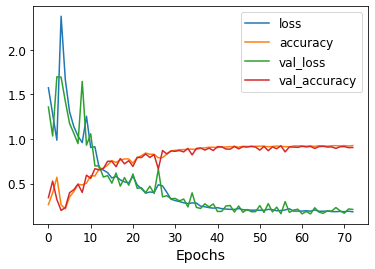

In [639]:
pd.DataFrame(best_model_history).plot(figsize=(6, 4))
plt.xlabel('Epochs', fontsize = 14)
plt.show()

Also in this case, the model does not seem to overfit over the train set. Again, the model reach the early stop before to run all the epochs.

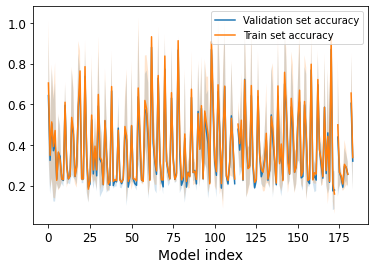

In [640]:
ax = plot_score(results, score_name='accuracy')
ax.set_xlabel('Model index', fontsize=14)
plt.legend(fontsize=10)
plt.show()

In [641]:
best_model.model.evaluate(X_test, y_test_scaled, verbose = 0)

[0.35272613167762756, 0.8609958291053772]

In [642]:
best_model.model.evaluate(X_train, y_train_scaled, verbose = 0)

[0.18738052248954773, 0.9236770868301392]

In [669]:
y_pred = best_model.model.predict_classes(X_test) + 1 

In [702]:
print(classification_report(y_test, y_pred, 
                      target_names=activities.values()))

                    precision    recall  f1-score   support

           WALKING       0.89      0.96      0.92       496
  WALKING_UPSTAIRS       0.85      0.85      0.85       471
WALKING_DOWNSTAIRS       0.91      0.82      0.86       420
           SITTING       0.86      0.78      0.82       491
          STANDING       0.81      0.88      0.84       532

          accuracy                           0.86      2410
         macro avg       0.86      0.86      0.86      2410
      weighted avg       0.86      0.86      0.86      2410



In [682]:
class_report_df = pd.DataFrame(classification_report(y_test, y_pred, 
                      target_names=activities.values(),
                      output_dict=True))

In [683]:
class_report_df

,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,accuracy,macro avg,weighted avg
precision,0.889925,0.854701,0.905759,0.855556,0.813589,0.860996,0.863906,0.861947
recall,0.961694,0.849257,0.823810,0.784114,0.877820,0.860996,0.859339,0.860996
f1-score,0.924419,0.851970,0.862843,0.818278,0.844485,0.860996,0.860399,0.860259
support,496.000000,471.000000,420.000000,491.000000,532.000000,0.860996,2410.000000,2410.000000


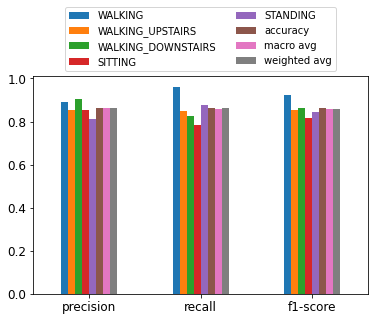

In [715]:
ax = class_report_df.iloc[:-1,:].plot(kind = 'bar', rot=0)
ax.legend(loc='lower center', ncol=2, fontsize=10,
           bbox_to_anchor=(0, 1, 1, 1))
plt.show()

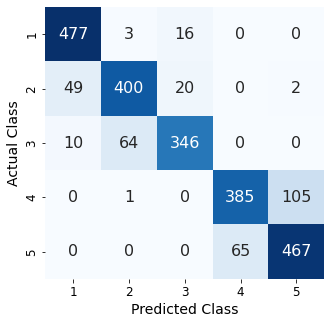

In [713]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_mtx(cm, figsize=(5, 5))
plt.show()

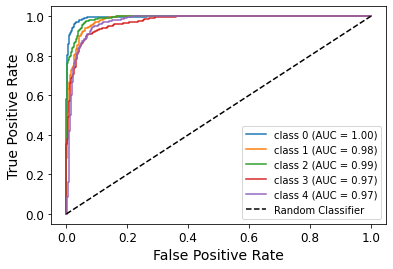

In [731]:
ax = plot_multiclass_roc(best_model, X_test, y_test_scaled)
ax.legend(fontsize='10')
plt.show()

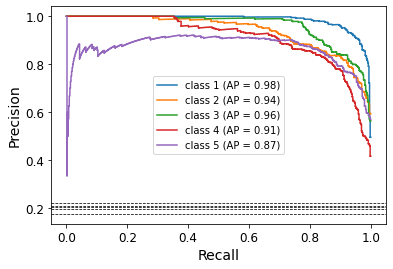

In [752]:
ax = plot_multiclass_prec_rec(best_model, X_test, y_test_scaled)
ax.legend(fontsize='small')
plt.show()

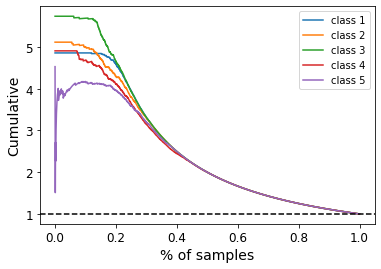

In [753]:
ax = plot_multiclass_lift(best_model, X_test, y_test_scaled, baseline=True)
ax.legend(fontsize='small')
plt.show()

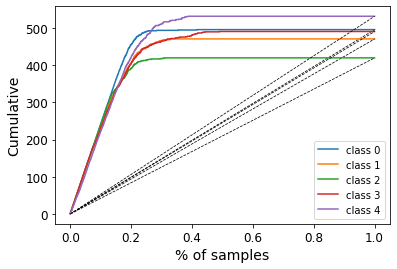

In [770]:
ax = plot_multiclass_gain(best_model, X_test, y_test_scaled, baseline=True)
ax.legend(fontsize='small')
plt.show()